In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
from tqdm import tqdm
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import scipy.stats as stats

# CMA aging Atlas: Liver from 10x.
Data downloaded from [Tabula muris senis](https://cellxgene.cziscience.com/collections/0b9d8a04-bb9d-44da-aa27-705bb65b54eb) project. Liver data, 10X 3'v2 assay in .h5ad format was used for further analysis. Decision made to cover absence of Kuppfer cells female young in the Smart-seq2 database.

## Importing and preprocessing data

In [2]:
# Directories
input_dir = r'/home/adrianmartin/Onedrive_IMDEA/Old_labs/Cuervo_lab/Dendra_paper/Raw_data/'
modelmx = r'/home/adrianmartin/Onedrive_IMDEA/Old_labs/Cuervo_lab/Dendra_paper/Raw_data/activation_model.xlsx' 
output_dir = r'/home/adrianmartin/Onedrive_IMDEA/Old_labs/Cuervo_lab/Dendra_paper/Revision_1/Output/Liver10x/'

In [3]:
# Import h5ad file in scanpy. 
adata = sc.read_h5ad(input_dir + '/TM_liver_10x.h5ad')

# Normalize as CPM (counts per million)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)

# Transforming CPM into log form
sc.pp.log1p(adata)

## CMA score calculation

In [4]:
# Load matrix file with weight and direction 
model_matrix = pd.read_excel(modelmx, 'reordered')

# No need to remove EEF1A1 and RAC1 genes, in 10X approach they appeared

# Finding CMA network genes in the dataset
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# Calculating the Zs scores
cma_data_zs = cma_network.copy().X.todense().T

for i in tqdm(np.arange(cma_data_zs.shape[0])):
    
    µ = np.mean(cma_data_zs[i, :])
    sd = np.std(cma_data_zs[i, :])
    
    cma_data_zs[i, :] = (cma_data_zs[i, :] - µ)/sd
    
# Generating a copy of adata.obs to work with
barcode = adata.obs.copy()

# New column in barcode (aka adata.obs) with the CMA scores for each cell detected
for i,j in enumerate(barcode.index):
        
    cell_matrix = model_matrix.copy()

    for g in cell_matrix.index:

        cell_matrix.loc[g, 'gene_count'] = cma_data_zs[g, i]

    cell_matrix['gene_score'] = cell_matrix['gene_count'] * cell_matrix['Direction'] * cell_matrix['Weight']
    score = cell_matrix['gene_score'].sum()/np.sum(cell_matrix['Weight'])

    barcode.loc[j, 'score'] = score   
    

100%|██████████| 18/18 [00:00<00:00, 12625.00it/s]


In [5]:
barcode.head()

,age,cell,free_annotation,method,donor_id,n_genes,subtissue,n_counts,louvain,leiden,...,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGATGTCGG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAACCTGAGATGTCGG,nan,droplet,18-F-51,1116.0,Hepatocytes,3650.349121,0,5,...,hepatocyte,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,ghq^6>2Cj>,-0.802075
AAAGCAATCGGAAATA-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGCAATCGGAAATA,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1976.0,Hepatocytes,4931.057617,1,1,...,hepatocyte,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,0AZ4zIEVgc,0.022095
AAAGTAGAGGCCCTTG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGTAGAGGCCCTTG,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1897.0,Hepatocytes,5164.586426,1,1,...,hepatocyte,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,W7+}-!fosq,-0.367614
AACCGCGAGAAACCGC-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACCGCGAGAAACCGC,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1501.0,Hepatocytes,4340.568359,1,1,...,hepatocyte,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,5zbU*lX{gq,-0.307166
AACTCCCAGTTGTCGT-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACTCCCAGTTGTCGT,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1710.0,Hepatocytes,4656.192871,1,1,...,hepatocyte,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,wvv9<D^@o-,-0.265595


## Dataset statistics

In [6]:
# Output dir for cell counts
output_dir = r'/home/adrianmartin/Onedrive_IMDEA/Old_labs/Cuervo_lab/Dendra_paper/Revision_1/Output/'

In [7]:
# Generating new ages
for j in barcode.index:    
    if barcode.loc[j, 'age'] == '1m' or barcode.loc[j, 'age'] == '3m':        
        barcode.loc[j, 'stats_age'] = 'Young'

    else:                        
        barcode.loc[j, 'stats_age'] = 'Old'

In [8]:
# Exploring cell counts
data = barcode[barcode['cell_type'].isin(['hepatocyte', 'Kupffer cell'])].value_counts(['cell_type', 'sex', 'stats_age', 'donor_id']).reset_index()
data.sort_values(by=['cell_type', 'sex', 'stats_age', 'donor_id'], 
                 ascending=[True, True, False, True], inplace=True)
data.reset_index(drop=True, inplace=True)
data.rename(columns={0: 'Counts'}, inplace=True)
data

,cell_type,sex,stats_age,donor_id,Counts
0,Kupffer cell,female,Young,3-F-56,12
1,Kupffer cell,female,Young,3-F-57,1
2,Kupffer cell,female,Old,18-F-51,221
3,Kupffer cell,female,Old,21-F-54,25
4,Kupffer cell,male,Young,1-M-62,5
5,Kupffer cell,male,Young,1-M-63,609
6,Kupffer cell,male,Old,24-M-59,18
7,Kupffer cell,male,Old,30-M-3,1608
8,Kupffer cell,male,Old,30-M-4,3
9,Kupffer cell,male,Old,30-M-5,44


In [15]:
# Function to extract cell counts
def datastats(cellpop):
    data2 = data[data.cell_type==cellpop]
    data2['Sex_age'] = data2['sex'].astype('str') + '_' + data2['stats_age'].astype('str')
    data2 = data2[['Sex_age', 'donor_id', 'Counts']]
    data2.sort_values(by=['Sex_age', 'donor_id', 'Counts'], ascending=[False, True, True],
                      inplace=True)
    custom_order = ['female_Young', 'female_Old', 'male_Young', 'male_Old']
    data2['Sex_age'] = pd.Categorical(data2['Sex_age'], categories=custom_order, ordered=True)

    data2 = data2.pivot_table(index='donor_id', columns='Sex_age', values='Counts', 
                              aggfunc='first')

    data2.reset_index(inplace=True)
    with pd.ExcelWriter(output_dir + "Cell_counts.xlsx", mode="a", if_sheet_exists='replace', 
                        engine="openpyxl") as writer:
        data2.to_excel(writer, sheet_name=cellpop[:6], index=True)

In [16]:
for i in ['hepatocyte', 'Kupffer cell']:
    datastats(cellpop=i)

## CMA net score/cell type (fold over whole tissue)

**Mice n for Liver**
    - Young females: 2
    - Young males: 3
    - Old females: 2
    - Old males: 5

In [9]:
# Generating new ages
for j in barcode.index:    
    if barcode.loc[j, 'age'] == '1m':        
        barcode.loc[j, 'new_age'] = '1-3m'
    
    elif barcode.loc[j, 'age'] == '3m':                
        barcode.loc[j, 'new_age'] = '1-3m'

    elif barcode.loc[j, 'age'] == '18m':                
        barcode.loc[j, 'new_age'] = '18-30m'

    elif barcode.loc[j, 'age'] == '21m': 
        barcode.loc[j, 'new_age'] = '18-30m'
    
    elif barcode.loc[j, 'age'] == '24m':                
        barcode.loc[j, 'new_age'] = '18-30m'

    elif barcode.loc[j, 'age'] == '30m':                
        barcode.loc[j, 'new_age'] = '18-30m'

barcode.head()

,age,cell,free_annotation,method,donor_id,n_genes,subtissue,n_counts,louvain,leiden,...,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGATGTCGG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAACCTGAGATGTCGG,nan,droplet,18-F-51,1116.0,Hepatocytes,3650.349121,0,5,...,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,ghq^6>2Cj>,-0.802075,18-30m
AAAGCAATCGGAAATA-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGCAATCGGAAATA,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1976.0,Hepatocytes,4931.057617,1,1,...,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,0AZ4zIEVgc,0.022095,18-30m
AAAGTAGAGGCCCTTG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGTAGAGGCCCTTG,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1897.0,Hepatocytes,5164.586426,1,1,...,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,W7+}-!fosq,-0.367614,18-30m
AACCGCGAGAAACCGC-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACCGCGAGAAACCGC,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1501.0,Hepatocytes,4340.568359,1,1,...,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,5zbU*lX{gq,-0.307166,18-30m
AACTCCCAGTTGTCGT-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACTCCCAGTTGTCGT,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1710.0,Hepatocytes,4656.192871,1,1,...,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,wvv9<D^@o-,-0.265595,18-30m


In [7]:
# Calculation of net score to 3m using whole tissue CMA score mean
µ = np.mean(barcode[barcode['new_age'] == '1-3m']['score'])

for i in barcode.index:
    barcode.loc[i, 'net_score'] = barcode.loc[i, 'score'] - µ 

barcode.head()

,age,cell,free_annotation,method,donor_id,n_genes,subtissue,n_counts,louvain,leiden,...,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age,net_score
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGATGTCGG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAACCTGAGATGTCGG,nan,droplet,18-F-51,1116.0,Hepatocytes,3650.349121,0,5,...,normal,Mus musculus,female,liver,na,18 month-old stage,ghq^6>2Cj>,-0.802075,18-30m,-0.784992
AAAGCAATCGGAAATA-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGCAATCGGAAATA,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1976.0,Hepatocytes,4931.057617,1,1,...,normal,Mus musculus,female,liver,na,18 month-old stage,0AZ4zIEVgc,0.022095,18-30m,0.039177
AAAGTAGAGGCCCTTG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGTAGAGGCCCTTG,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1897.0,Hepatocytes,5164.586426,1,1,...,normal,Mus musculus,female,liver,na,18 month-old stage,W7+}-!fosq,-0.367614,18-30m,-0.350531
AACCGCGAGAAACCGC-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACCGCGAGAAACCGC,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1501.0,Hepatocytes,4340.568359,1,1,...,normal,Mus musculus,female,liver,na,18 month-old stage,5zbU*lX{gq,-0.307166,18-30m,-0.290083
AACTCCCAGTTGTCGT-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACTCCCAGTTGTCGT,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1710.0,Hepatocytes,4656.192871,1,1,...,normal,Mus musculus,female,liver,na,18 month-old stage,wvv9<D^@o-,-0.265595,18-30m,-0.248513


In [9]:
print(list(barcode.cell_type.unique()))

['hepatocyte', 'endothelial cell of hepatic sinusoid', 'Kupffer cell', 'hepatic stellate cell', 'natural killer cell', 'plasmacytoid dendritic cell', 'B cell', 'myeloid leukocyte', 'duct epithelial cell']


In [4]:
cells = ['hepatocyte', 'Kupffer cell'] 

## CMA net score/cell type & sex (fold over each cell type young)

In [8]:
# Calculation of net score (fold to 3m for each individual cell type)
for maj_cell in tqdm(np.unique(barcode['cell_type'])):
    
    µ = np.mean(barcode[barcode['cell_type'] == maj_cell][barcode['new_age'] == '1-3m']['score'])
    
    for cell_index in barcode[barcode['cell_type'] == maj_cell].index:
    
        barcode.loc[cell_index, 'celltype_ns'] = barcode.loc[cell_index, 'score'] - µ  

barcode.head()

100%|██████████| 9/9 [00:00<00:00, 22.10it/s]


,age,cell,free_annotation,method,donor_id,n_genes,subtissue,n_counts,louvain,leiden,...,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age,net_score,celltype_ns
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGATGTCGG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAACCTGAGATGTCGG,nan,droplet,18-F-51,1116.0,Hepatocytes,3650.349121,0,5,...,Mus musculus,female,liver,na,18 month-old stage,ghq^6>2Cj>,-0.802075,18-30m,-0.784992,-0.825102
AAAGCAATCGGAAATA-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGCAATCGGAAATA,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1976.0,Hepatocytes,4931.057617,1,1,...,Mus musculus,female,liver,na,18 month-old stage,0AZ4zIEVgc,0.022095,18-30m,0.039177,-0.000933
AAAGTAGAGGCCCTTG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGTAGAGGCCCTTG,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1897.0,Hepatocytes,5164.586426,1,1,...,Mus musculus,female,liver,na,18 month-old stage,W7+}-!fosq,-0.367614,18-30m,-0.350531,-0.390641
AACCGCGAGAAACCGC-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACCGCGAGAAACCGC,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1501.0,Hepatocytes,4340.568359,1,1,...,Mus musculus,female,liver,na,18 month-old stage,5zbU*lX{gq,-0.307166,18-30m,-0.290083,-0.330193
AACTCCCAGTTGTCGT-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACTCCCAGTTGTCGT,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1710.0,Hepatocytes,4656.192871,1,1,...,Mus musculus,female,liver,na,18 month-old stage,wvv9<D^@o-,-0.265595,18-30m,-0.248513,-0.288623


### Graphs

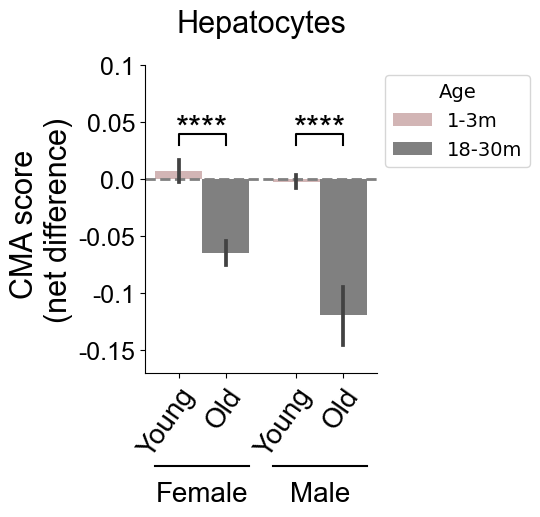

In [10]:
# Figure Hepatocytes
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.cell_type=='hepatocyte'], 
            hue='new_age', order=["female", "male"], hue_order=['1-3m', "18-30m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.17, 0.10)
ax.set_yticks([-0.15, -0.10, -0.05, 0.00, 0.05, 0.10])
ax.set_yticklabels([-0.15, -0.10, -0.05, 0.00, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['1-3m', "18-30m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Hepatocytes', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.03 , 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = -0.2, .2   
y, h, col = 0.03 , 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})
 
# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig(output_dir + '/Hepat10x_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

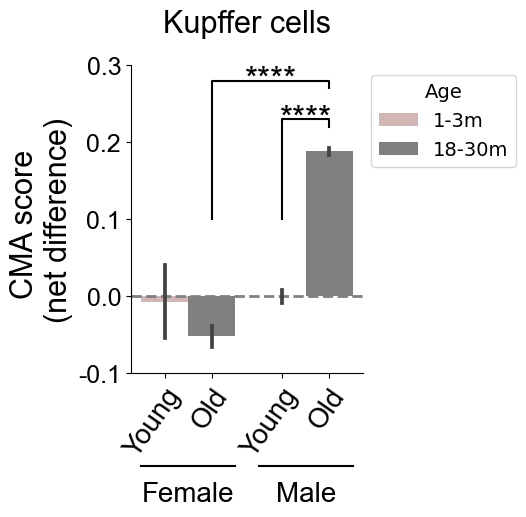

In [11]:
# Figure Kupffer cells
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.cell_type=='Kupffer cell'], 
            hue='new_age', order=["female", "male"], hue_order=['1-3m', "18-30m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.10, 0.30)
ax.set_yticks([-0.10, 0.00, 0.10, 0.20, 0.30])
ax.set_yticklabels([-0.10, 0.00, 0.10, 0.20, 0.30], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['1-3m', "18-30m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Kupffer cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# statistical annotation
x1, x2 = 0.8, 1.2   
y1, y2, h, col = 0.1, 0.22, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y1, y2+h, y2+h, y2], lw=1.5, c=col)
plt.text((x1+x2)*.5, y2-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = 0.2, 1.2   
y1, y2, h, col = 0.1, 0.27, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y1, y2+h, y2+h, y2], lw=1.5, c=col)
plt.text((x1+x2)*.5, y2-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig(output_dir + '/Kupf10x_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [12]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y].index)
                m = np.mean(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])
                s = stats.sem(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    df_raw.to_excel(output_dir + "/Liv10x_Raw_data.xlsx", sheet_name="CellNsbysex", index=False)
        
    return(df_raw)

In [13]:
raw(tipos = cells, edad=['1-3m', '18-30m'], sex=['female', 'male'])

,Cell_type,Age,Sex,n,Mean,SEM
0,hepatocyte,1-3m,female,536,0.006880,0.009703
1,hepatocyte,1-3m,male,1768,-0.002086,0.005158
2,hepatocyte,18-30m,female,517,-0.064934,0.010560
3,hepatocyte,18-30m,male,108,-0.119131,0.026078
4,Kupffer cell,1-3m,female,13,-0.006926,0.049874
5,Kupffer cell,1-3m,male,614,0.000147,0.008274
6,Kupffer cell,18-30m,female,246,-0.051975,0.012770
7,Kupffer cell,18-30m,male,1673,0.187961,0.004537


## CMA network heatmaps by cell type & sex

In [14]:
# Load matrix reordered
model_matrix = pd.read_excel(modelmx, 'reordered')

# Mapping data from adata to new order of CMA network
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# GFAP does not appear in some cell types, creating a list without it
nogfap = ['LAMP2', 'HSPA8', 'HSP90AA1', 'HSP90AB1', 'DNAJB1', 'EEF1A1', 'PHLPP1', 'RAC1', 'NFATC1', 'NCOR1', 'NFE2L2', 
          'RAB11A', 'RICTOR', 'AKT1', 'AKT2', 'CTSA', 'RARA']

In [15]:
def sex_heatmaps(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((18, 4))
    
    #Find cell indices for each condition
    female_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "1-3m"].index)
    female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-30m"].index)
    male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "1-3m"].index)
    male_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "18-30m"].index)
    
    #Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(cma_network[female_3m, :].X.todense()[:, rank])
        matrix[rank, 1] = np.mean(cma_network[female_18_24m, :].X.todense()[:, rank])
        matrix[rank, 2] = np.mean(cma_network[male_3m, :].X.todense()[:, rank])
        matrix[rank, 3] = np.mean(cma_network[male_18_24m, :].X.todense()[:, rank])
            
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd     
    
    # Saving raw data
    df_m = pd.DataFrame(matrix_zs, columns=['female_young', 'female_old', 'male_young', 'male_old'], 
                        index=model_matrix['Gene name'])
    with pd.ExcelWriter(output_dir + "/Liv10x_Raw_data.xlsx", mode="a", if_sheet_exists='replace',
                        engine="openpyxl", ) as writer:
        df_m.to_excel(writer, sheet_name=cellpop[:4]+'_heat', index=True)
        
    # Plotting with all proteins
    if cellpop == cells[1]:
        fig, ax = plt.subplots(figsize=(6,6))
        hfont = {'fontname':'Arial'}
        plt.imshow(matrix_zs, cmap='viridis', vmin=-1.5, vmax=1.5) 
        plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=16, **hfont)

        plt.yticks(np.arange(18), model_matrix['Gene name'], fontsize=16, **hfont)

        plt.ylim(17.5, -0.5)

        plt.xticks(np.arange(4), ['1-3m', '18-30m', '1-3m', '18-30m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=16, **hfont)
        plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)
        plt.title(label='Kupffer cells', fontdict={'family':'Arial', 'size': 22}, y=1.05)
        
        # Annotations
        trans = ax.get_yaxis_transform()
        trans2 = ax.get_xaxis_transform()
        ax.annotate('Effectors', xy=(-1.6, 0), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='k', size=16, **hfont)
        ax.plot([-1.35,-1.35],[-0.25, 4.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Pos. regulators', xy=(-1.6, 5.5), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='green', size=16, **hfont)
        ax.plot([-1.35,-1.35],[4.75, 12.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Neg. regulators', xy=(-1.6, 12), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='red', size=16, **hfont)
        ax.plot([-1.35,-1.35],[12.75, 17.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Female', xy=(0.05, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([-.5,1.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

        ax.annotate('Male', xy=(2.7, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([1.6, 3.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)
        
    else: # plotting without GFAP
        matrix_zs = np.delete(matrix_zs,(5), axis=0)
        fig, ax = plt.subplots(figsize=(6,6))
        hfont = {'fontname':'Arial'}
        plt.imshow(matrix_zs, cmap='viridis', vmin=-1.5, vmax=1.5) 
        plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=16, **hfont)

        plt.yticks(np.arange(17), nogfap, fontsize=16, **hfont)

        plt.ylim(16.5, -0.5)

        plt.xticks(np.arange(4), ['1-3m', '18-30m', '1-3m', '18-30m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=16, **hfont)
        plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)
        plt.title(label='Hepatocytes', fontdict={'family':'Arial', 'size': 22}, y=1.05)

        # Annotations
        trans = ax.get_yaxis_transform()
        trans2 = ax.get_xaxis_transform()
        ax.annotate('Effectors', xy=(-1.6, 0), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='k', size=16, **hfont)
        ax.plot([-1.35,-1.35],[-0.25, 4.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Pos. regulators', xy=(-1.6, 5.1), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='green', size=16, **hfont)
        ax.plot([-1.35,-1.35],[4.75, 11.15], color="k", transform=trans, clip_on=False)
        ax.annotate('Neg. regulators', xy=(-1.6, 11.3), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='red', size=16, **hfont)
        ax.plot([-1.35,-1.35],[11.75, 16.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Female', xy=(0.05, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([-.5,1.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

        ax.annotate('Male', xy=(2.7, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([1.6, 3.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

    
    plt.savefig(output_dir + '/{}_heat.png'.format(cellpop[:4]),bbox_inches='tight', dpi=300)
    
    plt.show()

100%|██████████| 18/18 [00:00<00:00, 18.11it/s]


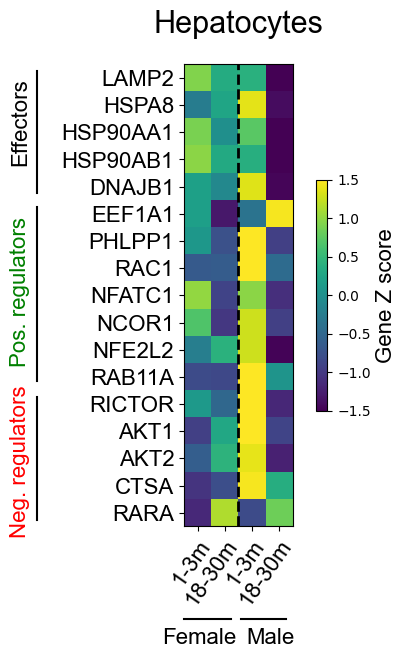

100%|██████████| 18/18 [00:01<00:00, 17.75it/s]


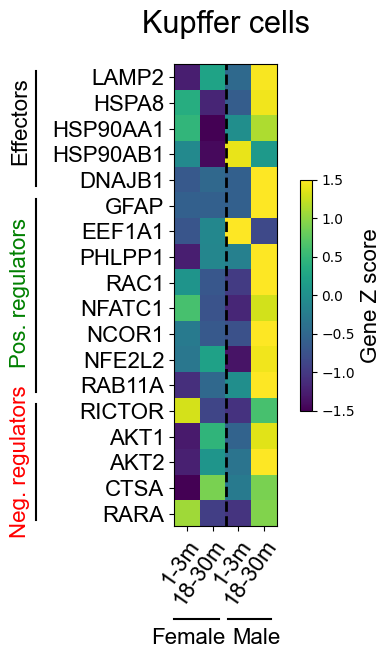

In [16]:
for i in cells:
    sex_heatmaps(cellpop=i)

# Lysosomal genes

In [10]:
# Directories
modelmx = r'/home/adrianmartin/Onedrive_IMDEA/Old_labs/Cuervo_lab/Dendra_paper/Raw_data/lysosomal_genes.xlsx' 

In [16]:
# Reading table with genes
genes = pd.read_excel(modelmx, 'Review_genes') 

In [18]:
# First trial finding genes in adata raised error, 
# so here we remove not found genes
notfound = ['ENSMUSG00000001418', 'ENSMUSG00000035953', 'ENSMUSG00000025793', 
            'ENSMUSG00000023826', 'ENSMUSG00000022270', 'ENSMUSG00000053647']

idx_val = genes.loc[genes['Ensembl Ms'].isin(notfound)].index.tolist()

# Removing genes not present
model_matrix = genes.drop(idx_val, axis=0).reset_index(drop=True)

# Finding genes of interest in the dataset
network = adata[:, model_matrix['Ensembl Ms']]

In [19]:
# Cell types of interest
cells = ['hepatocyte', 'Kupffer cell']

# Restricting our matrix to cells of interest
network = network[network.obs['cell_type'].isin(cells), :]

In [21]:
# Changes in network

# Adding gene symbols to network.var
network.var['Symbol'] = list(model_matrix['Symbol'])

# Generating new ages
for j in network.obs.index:    
    if network.obs.loc[j, 'age'] == '1m' or network.obs.loc[j, 'age'] == '3m':        
        network.obs.loc[j, 'new_age'] = 'Young'
    
    else:
        network.obs.loc[j, 'new_age'] = 'Old'

# hepatocyte cell_type to upper case and reset index
network.obs.cell_type.replace('hepatocyte', 'Hepatocyte', inplace=True)
network.obs.reset_index(inplace=True)

custom_age = ['Young', 'Old']

network.obs['new_age'] = pd.Categorical(network.obs['new_age'], 
                                         categories=custom_age, 
                                         ordered=True)

### Lysosome physiology genes

In [22]:
genes = model_matrix[model_matrix['Gene_set']=='Lysosomes']['Symbol'].to_list()
print(genes[:4])
len(genes)

['ASAH1', 'CTSA', 'CTSB', 'CTSD']


53

In [25]:
def lysosomes(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((53, 4))

    # Find genes in network.var
    genedf = network.copy()
    genedf.var.reset_index(inplace=True)
    genidx = list(genedf.var[genedf.var['Symbol'].isin(genes)].index)
    genedf = genedf[:, genidx[0]:genidx[-1]+1]
    
    
    #Find cell indices for each condition
    female_3m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "female"][genedf.obs['new_age'] == "Young"].index.astype(int))
    female_18_24m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "female"][genedf.obs['new_age'] == "Old"].index.astype(int))
    male_3m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "male"][genedf.obs['new_age'] == "Young"].index.astype(int))
    male_18_24m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "male"][genedf.obs['new_age'] == "Old"].index.astype(int))

    #Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(genedf[female_3m, rank].X.todense())
        matrix[rank, 1] = np.mean(genedf[female_18_24m, rank].X.todense())
        matrix[rank, 2] = np.mean(genedf[male_3m, rank].X.todense())
        matrix[rank, 3] = np.mean(genedf[male_18_24m, rank].X.todense())  
    
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd 

    # Saving raw data
    df_m = pd.DataFrame(matrix_zs, columns=['female_young', 'female_old', 'male_young', 'male_old'], 
                        index=genes)
    df_m.to_excel(output_dir + "Liv10x{}_raw.xlsx".format(cellpop[:3]), 
                  sheet_name='Lysosomes', index=True)


    #Plot heatmap including all conditions
    fig, ax = plt.subplots(figsize=(6,14))
    hfont = {'fontname':'Arial'}

    plt.imshow(matrix_zs, aspect=0.5, cmap='RdBu_r', vmin=-1.5, vmax=1.5)
    plt.colorbar(shrink=.25).set_label(label="Mean Z score", size=16, **hfont)

    plt.yticks(np.arange(53), genes, fontsize=16, **hfont)

    plt.ylim(52.5, -0.5)

    plt.xticks(np.arange(4), ['Young', 'Old', 'Young', 'Old'], 
               rotation=90, fontsize=16, **hfont)
    plt.title(cellpop.title()+'s', fontdict={'family':'Arial', 'size': 22}, y=1.05)
    
    plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

    # Annotations
    trans2 = ax.get_xaxis_transform()
    
    ax.annotate('F', xy=(0.4, -.08), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([-.5,1.25],[-.075,-.075], color="k", transform=trans2, clip_on=False)
    
    ax.annotate('M', xy=(2.6, -.08), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([1.5, 3.25],[-.075,-.075], color="k", transform=trans2, clip_on=False)
    
    plt.savefig(output_dir + 'liv10x{}lysheat.png'.format(cellpop[:3]),bbox_inches='tight', dpi=600)
    plt.show()

100%|██████████| 53/53 [00:01<00:00, 35.71it/s]


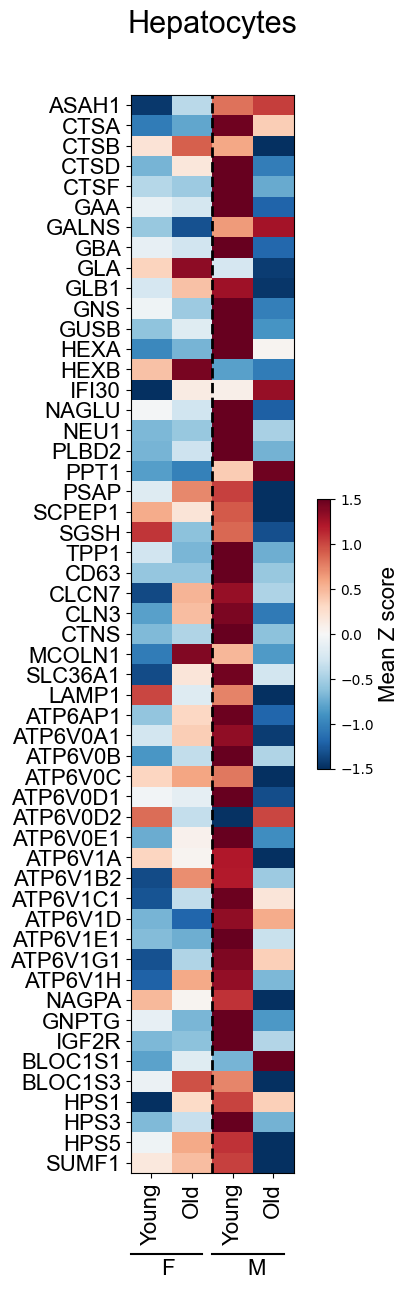

100%|██████████| 53/53 [00:01<00:00, 35.99it/s]


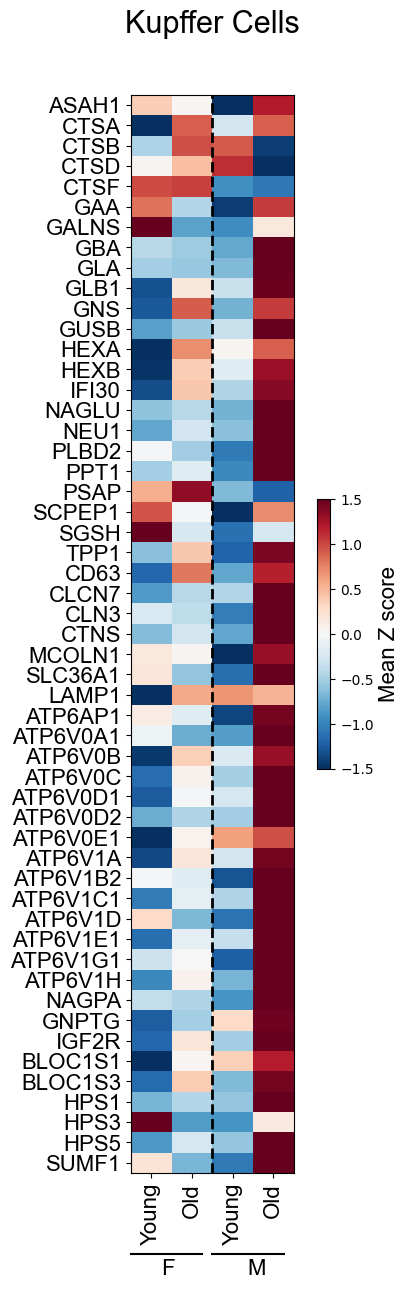

In [26]:
for i in ['Hepatocyte', 'Kupffer cell']:
    lysosomes(cellpop=i)

### Macroautophagy genes

In [51]:
genes = model_matrix[model_matrix['Gene_set']=='Macroautophagy']['Symbol'].to_list()
print(genes[:4])
len(genes)

['AMBRA1', 'ATG3', 'ATG4A', 'ATG4B']


82

In [31]:
# Heatmap for Macro genes
def macro(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((82, 4))

    # Find genes in network.var
    genedf = network.copy()
    genedf.var.reset_index(inplace=True)
    genidx = list(genedf.var[genedf.var['Symbol'].isin(genes)].index)
    genedf = genedf[:, genidx[0]:genidx[-1]+1]
    
    #Find cell indices for each condition
    female_3m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "female"][genedf.obs['new_age'] == "Young"].index.astype(int))
    female_18_24m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "female"][genedf.obs['new_age'] == "Old"].index.astype(int))
    male_3m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "male"][genedf.obs['new_age'] == "Young"].index.astype(int))
    male_18_24m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "male"][genedf.obs['new_age'] == "Old"].index.astype(int))

    #Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(genedf[female_3m, rank].X.todense())
        matrix[rank, 1] = np.mean(genedf[female_18_24m, rank].X.todense())
        matrix[rank, 2] = np.mean(genedf[male_3m, rank].X.todense())
        matrix[rank, 3] = np.mean(genedf[male_18_24m, rank].X.todense())  
    
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd
    
    # Saving raw data
    df_m = pd.DataFrame(matrix_zs, columns=['female_young', 'female_old', 'male_young', 'male_old'], 
                        index=genes)
    with pd.ExcelWriter(output_dir + "Liv10x{}_raw.xlsx".format(cellpop[:3]),
                        mode="a", if_sheet_exists='replace', engine="openpyxl", ) as writer:
        df_m.to_excel(writer, sheet_name='Macroautophagy', index=True)

    #Plot heatmap including all conditions
    fig, ax = plt.subplots(figsize=(6,18))
    hfont = {'fontname':'Arial'}

    plt.imshow(matrix_zs, aspect=0.5, cmap='RdBu_r',  vmin=-1.5, vmax=1.5)
    plt.colorbar(shrink=.25).set_label(label="Mean Z score", size=16, **hfont)

    plt.yticks(np.arange(82), genes, fontsize=16, **hfont)

    plt.ylim(81.5, -0.5)

    plt.xticks(np.arange(4), ['Young', 'Old', 'Young', 'Old'], 
               rotation=90, fontsize=16, **hfont)
    plt.title(cellpop.title()+'s', fontdict={'family':'Arial', 'size': 22}, y=1.05)
    
    plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

    # Annotations
    trans2 = ax.get_xaxis_transform()
    
    ax.annotate('F', xy=(0.4, -.08), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([-.5,1.25],[-.075,-.075], color="k", transform=trans2, clip_on=False)
    
    ax.annotate('M', xy=(2.6, -.08), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([1.5, 3.25],[-.075,-.075], color="k", transform=trans2, clip_on=False)
    
    plt.savefig(output_dir + 'liv10x{}MAheat.png'.format(cellpop[:3]),bbox_inches='tight', dpi=600)
    plt.show()

100%|██████████| 82/82 [00:01<00:00, 41.10it/s]


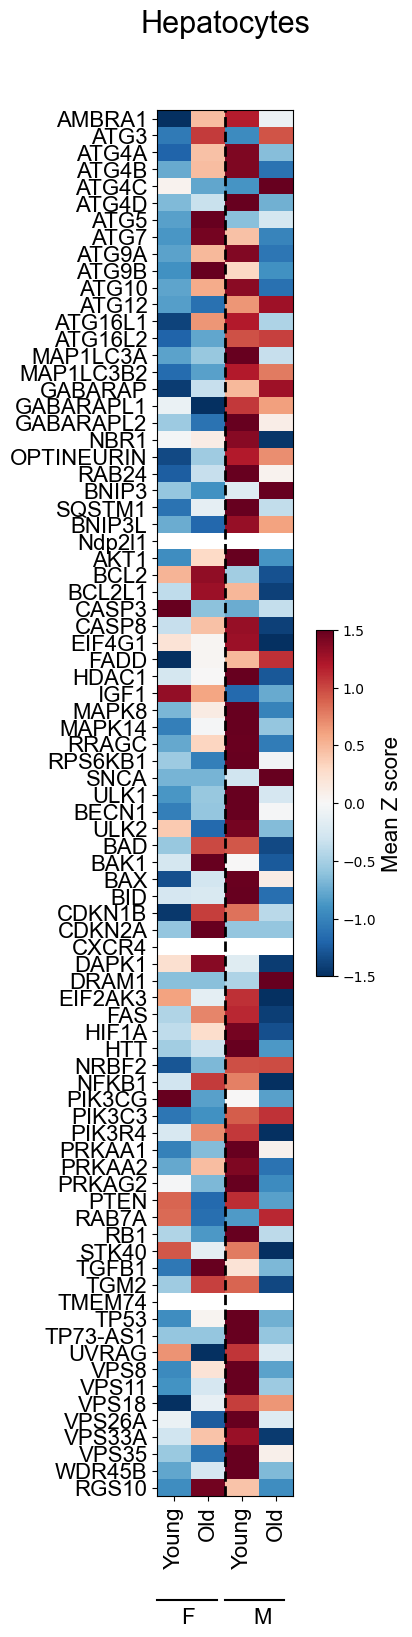

100%|██████████| 82/82 [00:02<00:00, 35.93it/s]


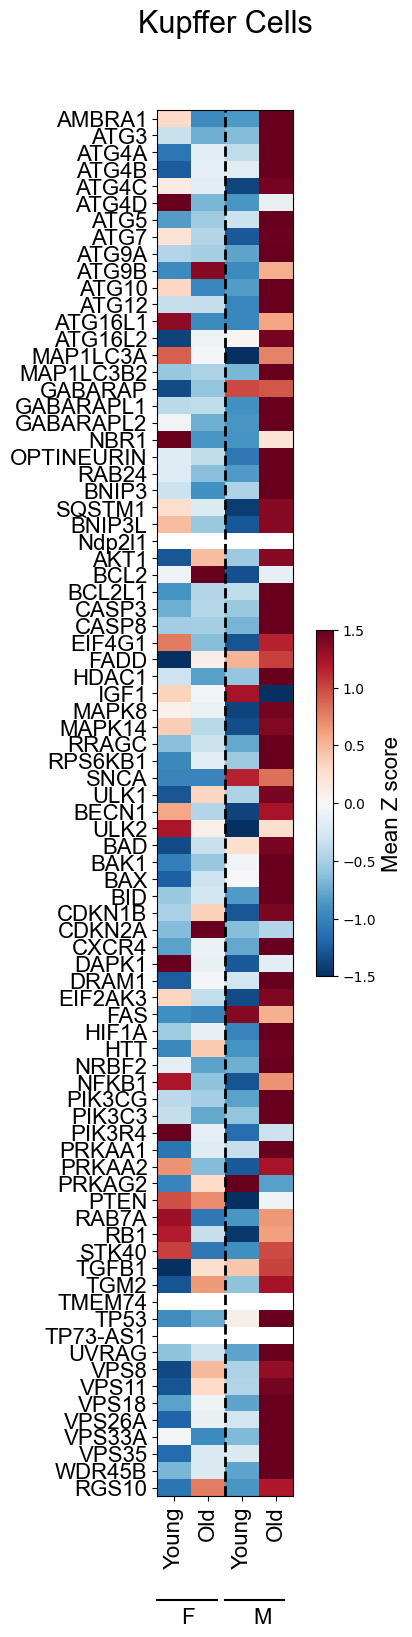

In [32]:
for i in ['Hepatocyte', 'Kupffer cell']:
    macro(cellpop=i)

### Selective MA

In [33]:
genes = model_matrix[model_matrix['Gene_set']=='Selective MA']['Symbol'].to_list()
print(genes[:4])
len(genes)

['Bcl2L13', 'PHB2', 'TAX1BP1', 'PINK']


13

In [34]:
def selective(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((13, 4))

    # Find genes in network.var
    genedf = network.copy()
    genedf.var.reset_index(inplace=True)
    genidx = list(genedf.var[genedf.var['Symbol'].isin(genes)].index)
    genedf = genedf[:, genidx[0]:genidx[-1]+1]
    
    #Find cell indices for each condition
    female_3m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "female"][genedf.obs['new_age'] == "Young"].index.astype(int))
    female_18_24m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "female"][genedf.obs['new_age'] == "Old"].index.astype(int))
    male_3m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "male"][genedf.obs['new_age'] == "Young"].index.astype(int))
    male_18_24m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "male"][genedf.obs['new_age'] == "Old"].index.astype(int))

    #Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(genedf[female_3m, rank].X.todense())
        matrix[rank, 1] = np.mean(genedf[female_18_24m, rank].X.todense())
        matrix[rank, 2] = np.mean(genedf[male_3m, rank].X.todense())
        matrix[rank, 3] = np.mean(genedf[male_18_24m, rank].X.todense())  
    
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd 

    # Saving raw data
    df_m = pd.DataFrame(matrix_zs, columns=['female_young', 'female_old', 'male_young', 'male_old'], 
                        index=genes)
    with pd.ExcelWriter(output_dir + "Liv10x{}_raw.xlsx".format(cellpop[:3]),
                        mode="a", if_sheet_exists='replace', engine="openpyxl", ) as writer:
        df_m.to_excel(writer, sheet_name='Selective MA', index=True)

    #Plot heatmap including all conditions
    fig, ax = plt.subplots(figsize=(3,9))
    hfont = {'fontname':'Arial'}

    plt.imshow(matrix_zs, aspect=0.5, cmap='RdBu_r')
    plt.colorbar(shrink=.25).set_label(label="Mean Z score", size=16, **hfont)

    plt.yticks(np.arange(13), genes, fontsize=16, **hfont)

    plt.ylim(12.5, -0.5)

    plt.xticks(np.arange(4), ['Young', 'Old', 'Young', 'Old'], 
               rotation=90, fontsize=16, **hfont)
    plt.title(cellpop.title()+'s', fontdict={'family':'Arial', 'size': 22}, y=1.05)
    
    plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

    # Annotations
    trans2 = ax.get_xaxis_transform()
    
    ax.annotate('F', xy=(0.4, -.27), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([-.5,1.25],[-.255,-.255], color="k", transform=trans2, clip_on=False)
    
    ax.annotate('M', xy=(2.6, -.27), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([1.5, 3.25],[-.255,-.255], color="k", transform=trans2, clip_on=False)
    
    plt.savefig(output_dir + 'liv10x{}selMAheat.png'.format(cellpop[:3]),bbox_inches='tight', dpi=600)
    plt.show()

100%|██████████| 13/13 [00:00<00:00, 37.45it/s]


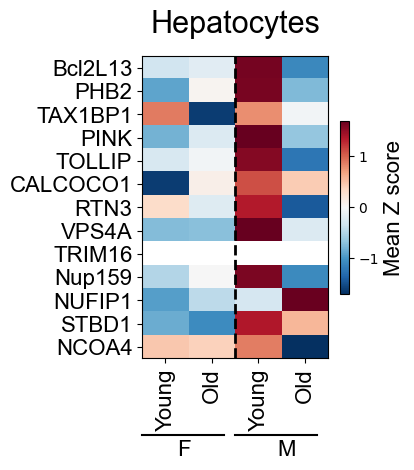

100%|██████████| 13/13 [00:00<00:00, 38.01it/s]


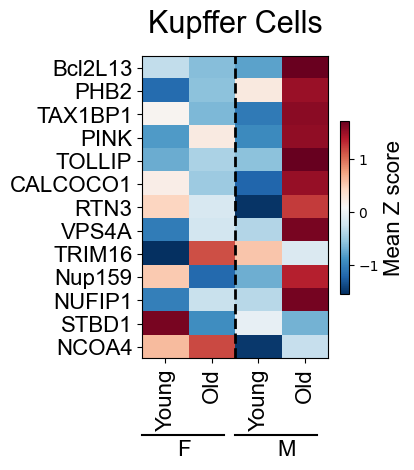

In [35]:
for i in ['Hepatocyte', 'Kupffer cell']:
    selective(cellpop=i)

### Extra lysosomal genes

In [5]:
# Directories
modelmx = r'/home/adrianmartin/Onedrive_IMDEA/Old_labs/Cuervo_lab/Dendra_paper/Raw_data/lysosomal_genes.xlsx' 

In [6]:
# Reading table with genes
modelmx = pd.read_excel(modelmx, 'LysExtra') 
genes = list(modelmx['Symbol'])

In [7]:
# Finding genes of interest in the dataset
network = adata[:, modelmx['Ensembl Ms']]
network.var_names

Index(['ENSMUSG00000023990', 'ENSMUSG00000000134', 'ENSMUSG00000029553'], dtype='object')

In [9]:
# Restricting our matrix to cells of interest
network = network[network.obs['cell_type'].isin(cells), :]

In [11]:
# Changes in network

# Adding gene symbols to network.var
network.var['Symbol'] = list(modelmx['Symbol'])

# Generating new ages
for j in network.obs.index:    
    if network.obs.loc[j, 'age'] == '1m' or network.obs.loc[j, 'age'] == '3m':        
        network.obs.loc[j, 'new_age'] = 'Young'
    
    else:
        network.obs.loc[j, 'new_age'] = 'Old'

# hepatocyte cell_type to upper case and reset index
network.obs.cell_type.replace('hepatocyte', 'Hepatocyte', inplace=True)
network.obs.reset_index(inplace=True)

custom_age = ['Young', 'Old']

network.obs['new_age'] = pd.Categorical(network.obs['new_age'], 
                                         categories=custom_age, 
                                         ordered=True)

In [12]:
def selective(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((3, 4))

    # Find genes in network.var
    genedf = network.copy()
    genedf.var.reset_index(inplace=True)
        
    #Find cell indices for each condition
    female_3m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "female"][genedf.obs['new_age'] == "Young"].index.astype(int))
    female_18_24m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "female"][genedf.obs['new_age'] == "Old"].index.astype(int))
    male_3m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "male"][genedf.obs['new_age'] == "Young"].index.astype(int))
    male_18_24m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "male"][genedf.obs['new_age'] == "Old"].index.astype(int))

    #Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(genedf[female_3m, rank].X.todense())
        matrix[rank, 1] = np.mean(genedf[female_18_24m, rank].X.todense())
        matrix[rank, 2] = np.mean(genedf[male_3m, rank].X.todense())
        matrix[rank, 3] = np.mean(genedf[male_18_24m, rank].X.todense())  
    
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd 

    # Saving raw data
    df_m = pd.DataFrame(matrix_zs, columns=['female_young', 'female_old', 'male_young', 'male_old'], 
                        index=genes)
    with pd.ExcelWriter(output_dir + "Liv10x{}_raw.xlsx".format(cellpop[:3]),
                        mode="a", if_sheet_exists='replace', engine="openpyxl", ) as writer:
        df_m.to_excel(writer, sheet_name='LysExtra', index=True)

    #Plot heatmap including all conditions
    fig, ax = plt.subplots(figsize=(3,5))
    hfont = {'fontname':'Arial'}

    plt.imshow(matrix_zs, aspect=0.5, cmap='RdBu_r')
    plt.colorbar(shrink=.25).set_label(label="Mean Z score", size=16, **hfont)

    plt.yticks(np.arange(3), genes, fontsize=16, **hfont)

    plt.ylim(2.5, -0.5)

    plt.xticks(np.arange(4), ['Young', 'Old', 'Young', 'Old'], 
               rotation=90, fontsize=16, **hfont)
    plt.title(cellpop.title()+'s', fontdict={'family':'Arial', 'size': 22}, y=1.05)
    
    plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

    # Annotations
    trans2 = ax.get_xaxis_transform()
    
    ax.annotate('F', xy=(0.4, -1.3), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([-.3,1.25],[-1.15,-1.15], color="k", transform=trans2, clip_on=False)
    
    ax.annotate('M', xy=(2.6, -1.3), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([1.7, 3.25],[-1.15,-1.15], color="k", transform=trans2, clip_on=False)
    
    plt.savefig(output_dir + 'liv10x{}lysextraheat.png'.format(cellpop[:3]),bbox_inches='tight', dpi=600)
    plt.show()

100%|██████████| 3/3 [00:00<00:00, 31.80it/s]


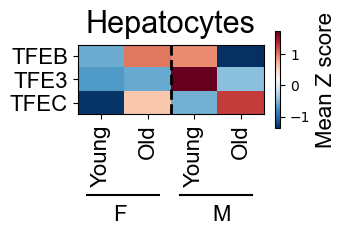

100%|██████████| 3/3 [00:00<00:00, 32.92it/s]


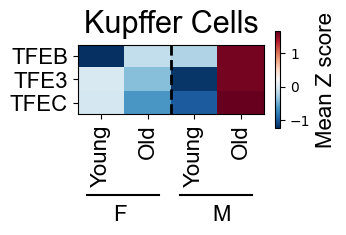

In [14]:
for i in ['Hepatocyte', 'Kupffer cell']:
    selective(cellpop=i)

## Macro score

In [11]:
# Load matrix file with weight and direction 
mamx = pd.read_excel(modelmx, 'Macroautophagy')

# Removing genes not present in the adata
mamx = mamx.drop(mamx[mamx["Ensembl Ms"] == 'ENSMUSG00000025793'].index, axis=0).reset_index(drop=True)

# Finding MA network genes in the dataset
ma_network = adata[:, mamx["Ensembl Ms"]]

In [12]:
# Calculating the Zs scores
ma_data_zs = ma_network.copy().X.todense().T

for i in tqdm(np.arange(ma_data_zs.shape[0])):
    
    µ = np.mean(ma_data_zs[i, :])
    sd = np.std(ma_data_zs[i, :])
    
    ma_data_zs[i, :] = (ma_data_zs[i, :] - µ)/sd

# New column in barcode (aka adata.obs) with the CMA scores for each cell detected
for i,j in tqdm(enumerate(barcode.index)):
        
    cell_matrix = mamx.copy()

    for g in cell_matrix.index:

        cell_matrix.loc[g, 'gene_count'] = ma_data_zs[g, i]

    cell_matrix['gene_score'] = cell_matrix['gene_count'] * cell_matrix['direction'] * cell_matrix['weight']
    score = cell_matrix['gene_score'].sum()/np.sum(cell_matrix['weight'])

    barcode.loc[j, 'ma_score'] = score   

barcode.head()
    

100%|██████████| 83/83 [00:00<00:00, 13170.67it/s]
7294it [00:23, 309.99it/s]


,age,cell,free_annotation,method,donor_id,n_genes,subtissue,n_counts,louvain,leiden,...,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age,net_score,celltype_ns,ma_score
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGATGTCGG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAACCTGAGATGTCGG,nan,droplet,18-F-51,1116.0,Hepatocytes,3650.349121,0,5,...,female,liver,na,18 month-old stage,ghq^6>2Cj>,-0.802075,18-30m,-0.784992,-0.825102,-0.232799
AAAGCAATCGGAAATA-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGCAATCGGAAATA,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1976.0,Hepatocytes,4931.057617,1,1,...,female,liver,na,18 month-old stage,0AZ4zIEVgc,0.022095,18-30m,0.039177,-0.000933,0.062220
AAAGTAGAGGCCCTTG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGTAGAGGCCCTTG,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1897.0,Hepatocytes,5164.586426,1,1,...,female,liver,na,18 month-old stage,W7+}-!fosq,-0.367614,18-30m,-0.350531,-0.390641,-0.002144
AACCGCGAGAAACCGC-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACCGCGAGAAACCGC,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1501.0,Hepatocytes,4340.568359,1,1,...,female,liver,na,18 month-old stage,5zbU*lX{gq,-0.307166,18-30m,-0.290083,-0.330193,-0.245189
AACTCCCAGTTGTCGT-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACTCCCAGTTGTCGT,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1710.0,Hepatocytes,4656.192871,1,1,...,female,liver,na,18 month-old stage,wvv9<D^@o-,-0.265595,18-30m,-0.248513,-0.288623,-0.066245


In [13]:
# Calculation of ma net score (fold to 3m for each individual cell type)
for maj_cell in tqdm(np.unique(barcode['cell_type'])):
    
    µ = np.mean(barcode[barcode['cell_type'] == maj_cell][barcode['new_age'] == '1-3m']['ma_score'])
    
    for cell_index in barcode[barcode['cell_type'] == maj_cell].index:
    
        barcode.loc[cell_index, 'macell_ns'] = barcode.loc[cell_index, 'ma_score'] - µ  

barcode.head()

100%|██████████| 9/9 [00:00<00:00, 21.99it/s]


,age,cell,free_annotation,method,donor_id,n_genes,subtissue,n_counts,louvain,leiden,...,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age,net_score,celltype_ns,ma_score,macell_ns
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGATGTCGG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAACCTGAGATGTCGG,nan,droplet,18-F-51,1116.0,Hepatocytes,3650.349121,0,5,...,liver,na,18 month-old stage,ghq^6>2Cj>,-0.802075,18-30m,-0.784992,-0.825102,-0.232799,-0.245175
AAAGCAATCGGAAATA-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGCAATCGGAAATA,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1976.0,Hepatocytes,4931.057617,1,1,...,liver,na,18 month-old stage,0AZ4zIEVgc,0.022095,18-30m,0.039177,-0.000933,0.062220,0.049844
AAAGTAGAGGCCCTTG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGTAGAGGCCCTTG,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1897.0,Hepatocytes,5164.586426,1,1,...,liver,na,18 month-old stage,W7+}-!fosq,-0.367614,18-30m,-0.350531,-0.390641,-0.002144,-0.014520
AACCGCGAGAAACCGC-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACCGCGAGAAACCGC,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1501.0,Hepatocytes,4340.568359,1,1,...,liver,na,18 month-old stage,5zbU*lX{gq,-0.307166,18-30m,-0.290083,-0.330193,-0.245189,-0.257565
AACTCCCAGTTGTCGT-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACTCCCAGTTGTCGT,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1710.0,Hepatocytes,4656.192871,1,1,...,liver,na,18 month-old stage,wvv9<D^@o-,-0.265595,18-30m,-0.248513,-0.288623,-0.066245,-0.078621


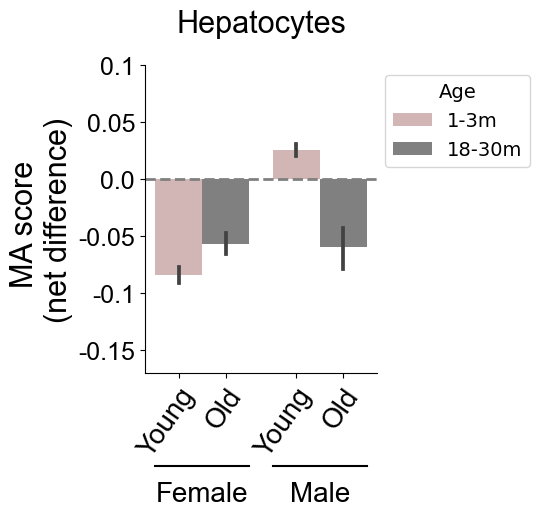

In [87]:
# Figure Hepatocytes
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='macell_ns', data=barcode[barcode.cell_type=='hepatocyte'], 
            hue='new_age', order=["female", "male"], hue_order=['1-3m', "18-30m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('MA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.17, 0.10)
ax.set_yticks([-0.15, -0.10, -0.05, 0.00, 0.05, 0.10])
ax.set_yticklabels([-0.15, -0.10, -0.05, 0.00, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['1-3m', "18-30m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Hepatocytes', fontdict={'family':'Arial', 'size': 22}, y=1.08)


# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig(output_dir + '/liv10xhepmans.png',bbox_inches='tight', dpi=600)

plt.show()

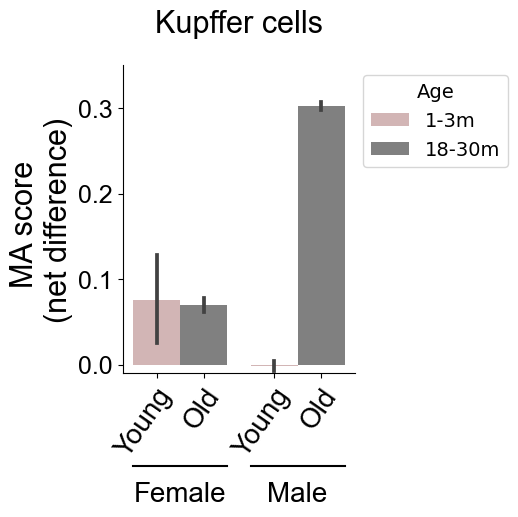

In [91]:
# Figure Kupffer cells
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='macell_ns', data=barcode[barcode.cell_type=='Kupffer cell'], 
            hue='new_age', order=["female", "male"], hue_order=['1-3m', "18-30m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.xlabel('')
plt.ylabel('MA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.01, 0.35)
ax.set_yticks([0.00, 0.10, 0.20, 0.30])
ax.set_yticklabels([0.00, 0.10, 0.20, 0.30], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['1-3m', "18-30m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Kupffer cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig(output_dir + '/liv10xkupmans.png',bbox_inches='tight', dpi=600)

plt.show()

In [82]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad=['1-3m', '18-30m'], sex=['female', 'male']):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for x in edad:
        for y in sex:
            n = len(barcode[barcode['cell_type']== tipos][barcode['new_age']== x][barcode['sex']== y].index)
            m = np.mean(barcode[barcode['cell_type']== tipos][barcode['new_age']== x][barcode['sex']== y]['macell_ns'])
            s = stats.sem(barcode[barcode['cell_type']== tipos][barcode['new_age']== x][barcode['sex']== y]['macell_ns'])

            long.append(n)
            celula.append(tipos)                
            age.append(x)
            sexo.append(y)
            mean.append(m)
            sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter(output_dir + "/Liv10x{}_raw.xlsx".format(tipos.capitalize()[:3]),
                        mode="a", if_sheet_exists='replace', engine="openpyxl", ) as writer:
        df_raw.to_excel(writer, sheet_name='MA score', index=True)

    print(df_raw)

In [92]:
for i in cells:
    raw(tipos = i)

    Cell_type     Age     Sex     n      Mean       SEM
0  hepatocyte    1-3m  female   536 -0.084136  0.007392
1  hepatocyte    1-3m    male  1768  0.025507  0.004998
2  hepatocyte  18-30m  female   517 -0.056444  0.009171
3  hepatocyte  18-30m    male   108 -0.059759  0.019069
      Cell_type     Age     Sex     n      Mean       SEM
0  Kupffer cell    1-3m  female    13  0.075537  0.052088
1  Kupffer cell    1-3m    male   614 -0.001599  0.005731
2  Kupffer cell  18-30m  female   246  0.069262  0.009074
3  Kupffer cell  18-30m    male  1673  0.302765  0.003997


## Correlation with hormone receptors

In [14]:
# Reading df for hormone receptors
horm = pd.read_excel(r'/home/adrianmartin/Onedrive_IMDEA/Old_labs/Cuervo_lab/Dendra_paper/Raw_data/lysosomal_genes.xlsx', 'Review_genes')
horm_symbol = horm[horm['Gene_set']=='Hormones']['Symbol'].to_list()
horm_ensembl = horm[horm['Gene_set']=='Hormones']['Ensembl Ms'].to_list()

In [15]:
# First trial finding genes in adata raised error, 
# so here we remove not found genes
horm_symbol = [i for i in horm_symbol if i != 'GPER1']
horm_ensembl = [i for i in horm_ensembl if i != 'ENSMUSG00000053647']

# Finding genes of interest in the dataset
hormdf = adata[:, horm_ensembl]
hormdf.layers["scaled"] = sc.pp.scale(hormdf, copy=True).X
hormdf

AnnData object with n_obs × n_vars = 7294 × 6
    obs: 'age', 'cell', 'free_annotation', 'method', 'donor_id', 'n_genes', 'subtissue', 'n_counts', 'louvain', 'leiden', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'age_colors', 'citation', 'leiden', 'louvain', 'neighbors', 'pca', 'schema_reference', 'schema_version', 'title', 'log1p'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'scaled'
    obsp: 'connec

In [16]:
# Dataframe with Hormone Zs values
hormzs = pd.DataFrame(hormdf.layers['scaled'], columns = horm_symbol, index=hormdf.obs.index)
hormzs.head()

,ESR1,ESR2,ANDR,PRGR,XIST,LAMP2
index,,,,,,
AAACCTGAGATGTCGG-1-9-0-0,-0.181544,0.0,-0.092360,-0.02342,2.644097,-2.118897
AAAGCAATCGGAAATA-1-9-0-0,-0.181544,0.0,-0.092360,-0.02342,1.882859,0.636972
AAAGTAGAGGCCCTTG-1-9-0-0,-0.181544,0.0,-0.092360,-0.02342,2.406539,0.544026
AACCGCGAGAAACCGC-1-9-0-0,-0.181544,0.0,-0.092360,-0.02342,2.333772,0.669766
AACTCCCAGTTGTCGT-1-9-0-0,-0.181544,0.0,11.480145,-0.02342,2.121636,0.614287


In [17]:
# Merging Barcode and Hormonze Z values dataframe
barcode = pd.merge(barcode, hormzs, how='inner', on='index')
barcode.head()

,age,cell,free_annotation,method,donor_id,n_genes,subtissue,n_counts,louvain,leiden,...,net_score,celltype_ns,ma_score,macell_ns,ESR1,ESR2,ANDR,PRGR,XIST,LAMP2
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGATGTCGG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAACCTGAGATGTCGG,nan,droplet,18-F-51,1116.0,Hepatocytes,3650.349121,0,5,...,-0.784992,-0.825102,-0.232799,-0.245175,-0.181544,0.0,-0.092360,-0.02342,2.644097,-2.118897
AAAGCAATCGGAAATA-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGCAATCGGAAATA,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1976.0,Hepatocytes,4931.057617,1,1,...,0.039177,-0.000933,0.062220,0.049844,-0.181544,0.0,-0.092360,-0.02342,1.882859,0.636972
AAAGTAGAGGCCCTTG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGTAGAGGCCCTTG,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1897.0,Hepatocytes,5164.586426,1,1,...,-0.350531,-0.390641,-0.002144,-0.014520,-0.181544,0.0,-0.092360,-0.02342,2.406539,0.544026
AACCGCGAGAAACCGC-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACCGCGAGAAACCGC,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1501.0,Hepatocytes,4340.568359,1,1,...,-0.290083,-0.330193,-0.245189,-0.257565,-0.181544,0.0,-0.092360,-0.02342,2.333772,0.669766
AACTCCCAGTTGTCGT-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACTCCCAGTTGTCGT,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1710.0,Hepatocytes,4656.192871,1,1,...,-0.248513,-0.288623,-0.066245,-0.078621,-0.181544,0.0,11.480145,-0.02342,2.121636,0.614287


In [18]:
def hormones (cellpop):
    for horm in horm_symbol:
        if horm == 'LAMP2':
            break
                
        # Dataframe for non-zero hormone values
        filt = barcode[barcode.cell_type==cellpop]
        filt = filt[filt[horm] > np.min(filt[horm])]

        # Saving raw data
        df = filt[['cell_type', 'sex', 'new_age', 'celltype_ns', horm]]
        with pd.ExcelWriter(output_dir + "Liv10x{}_raw.xlsx".format(cellpop.capitalize()[:3]),
                            mode="a", if_sheet_exists='replace', engine="openpyxl", ) as writer:
            df.to_excel(writer, sheet_name='{}_corr'.format(horm), index=True)
        
        # Figure
        plot = sns.lmplot(filt, x="celltype_ns", y=horm, hue="sex", 
           hue_order = ("female", "male"), #palette=['#D7B0B0', '#808080'],
           col='new_age', col_wrap=2, col_order=['1-3m', '18-30m'], legend_out = True)
        titles = ['Young', 'Old']
        for ax, title in zip(plot.axes.flat, titles):
            ax.set_title(title, fontsize=16)
        plot.set_axis_labels("CMA Net Score", "{} Z-score".format(horm), fontsize=14)

        for ax in plot.axes.flat:
            ax.tick_params(axis='x', labelsize=12)
            ax.tick_params(axis='y', labelsize=12)

        new_labels = ['Female', 'Male']  # Nuevos labels para la leyenda
        for t, l in zip(plot._legend.texts, new_labels):
            t.set_text(l)
        plt.setp(plot._legend.get_title(), fontsize=14)  
        plt.setp(plot._legend.get_texts(), fontsize=12)
        plot._legend.set_title('Sex')

        plt.savefig(output_dir + '/liv10x{}{}.png'.format(cellpop.capitalize()[:3], horm),bbox_inches='tight', dpi=600)

        plt.show()

        if horm == 'XIST':
            filt2 = filt[filt['LAMP2'] > np.min(filt['LAMP2'])]
            # Saving raw data
            df = filt2[['cell_type', 'sex', 'new_age', 'celltype_ns', horm, 'LAMP2']]
            with pd.ExcelWriter(output_dir + "Liv10x{}_raw.xlsx".format(cellpop.capitalize()[:3]),
                                mode="a", if_sheet_exists='replace', engine="openpyxl", ) as writer:
                df.to_excel(writer, sheet_name='{}-L2_corr'.format(horm), index=True)
            
            # XIST-LAMP2 correlation
            plot = sns.lmplot(data=filt2, x="XIST", y="LAMP2", hue='sex', hue_order = ("female", "male"),
                              col='new_age', col_wrap=2, col_order=['1-3m', '18-30m'], 
                              legend_out = True)
            titles = ['Young', 'Old']
            for ax, title in zip(plot.axes.flat, titles):
                ax.set_title(title, fontsize=16)
            plot.set_axis_labels("XIST Z-score", "LAMP2 Z-score", fontsize=14)

            for ax in plot.axes.flat:
                ax.tick_params(axis='x', labelsize=12)
                ax.tick_params(axis='y', labelsize=12)

            new_labels = ['Female', 'Male']  # Nuevos labels para la leyenda
            for t, l in zip(plot._legend.texts, new_labels):
                t.set_text(l)
            plt.setp(plot._legend.get_title(), fontsize=14)  
            plt.setp(plot._legend.get_texts(), fontsize=12)
            plot._legend.set_title('Sex')  # Nuevos labels para la leyenda

            plt.savefig(output_dir + '/liv10x{}xisl2.png'.format(cellpop.capitalize()[:3]),bbox_inches='tight', dpi=600)

            plt.show()
    print('Loop finished')

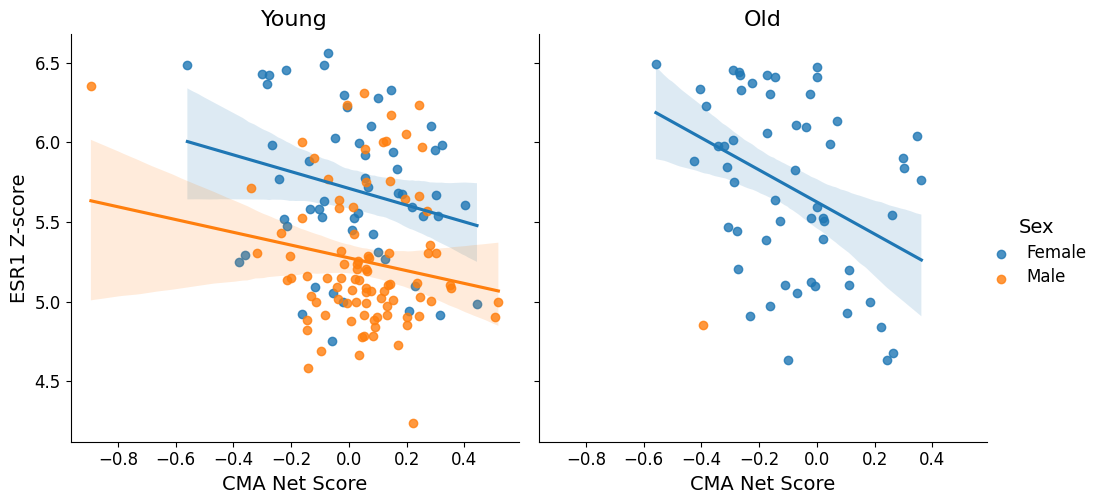

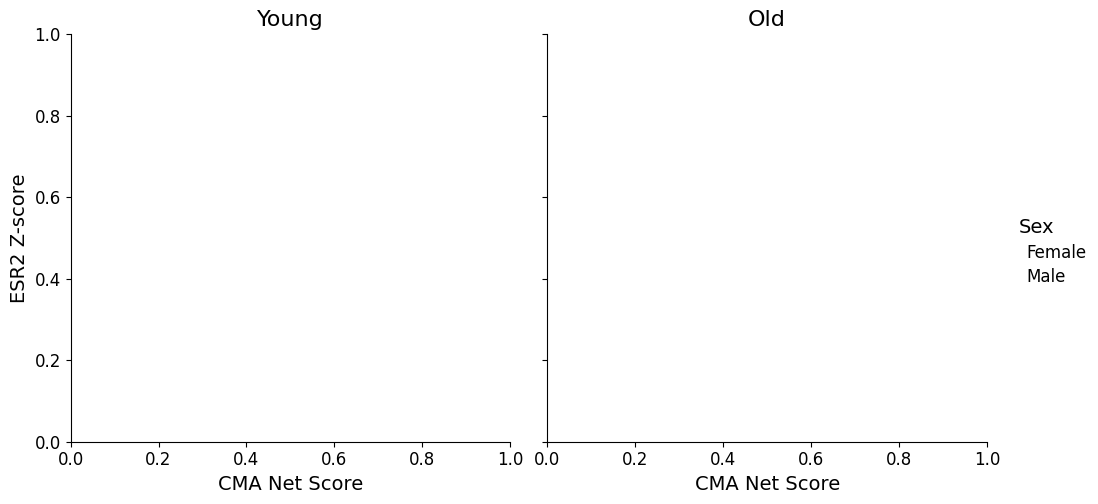

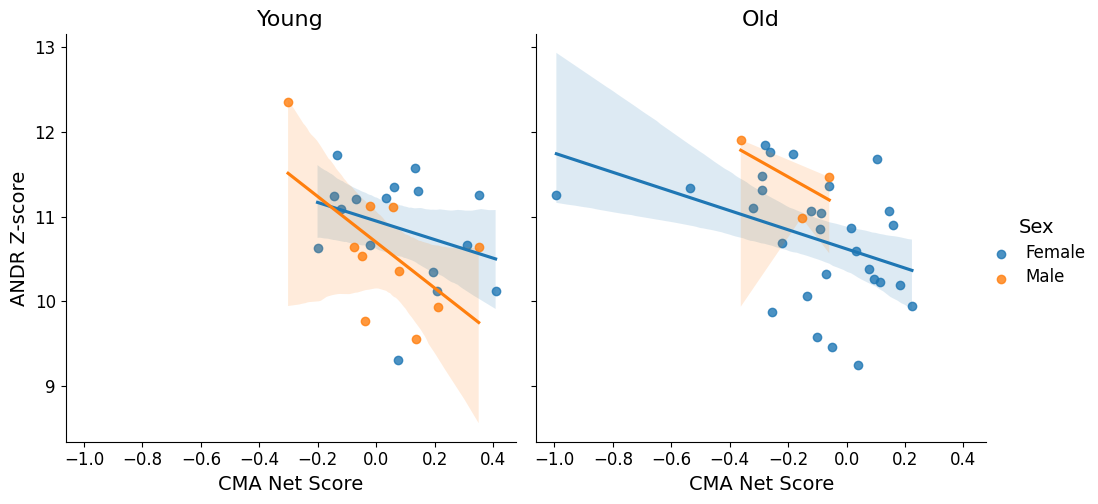

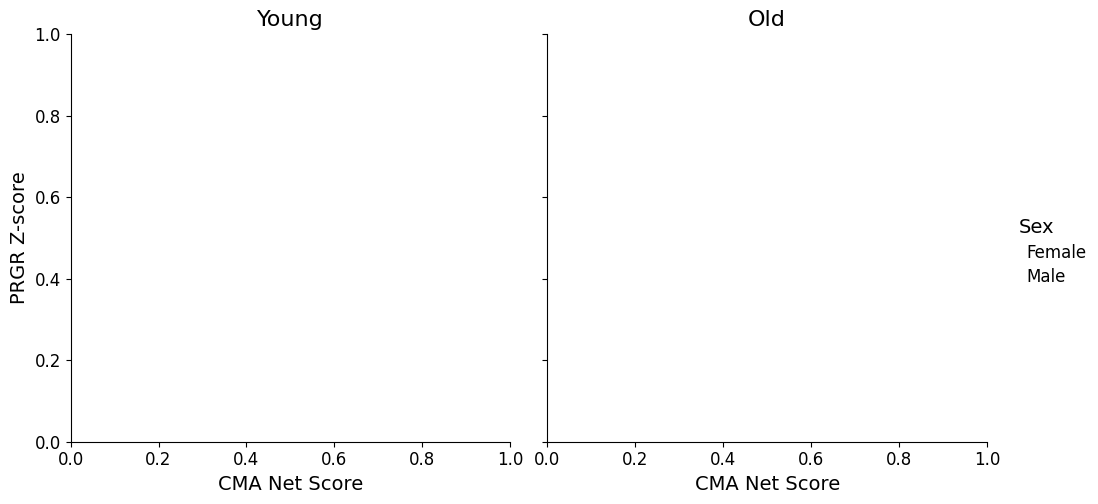

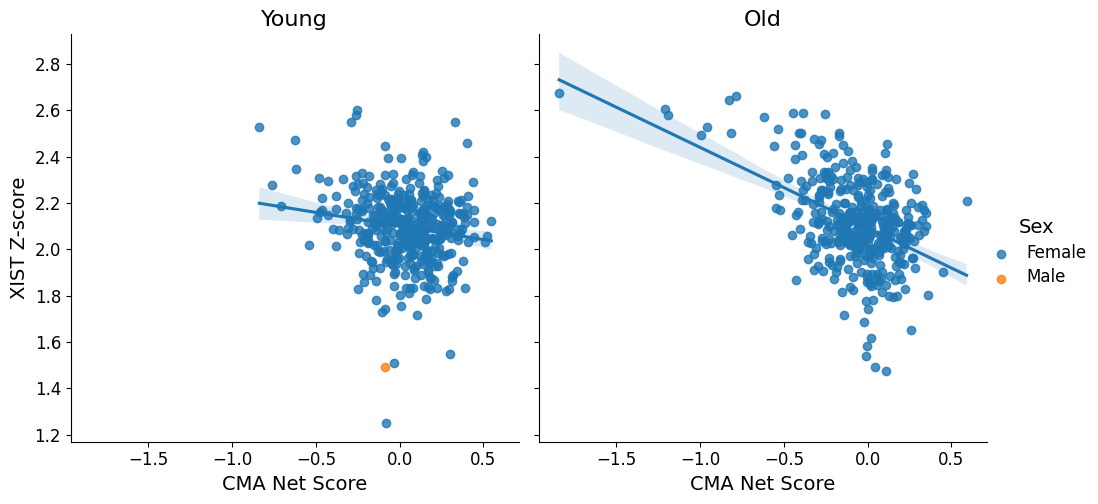

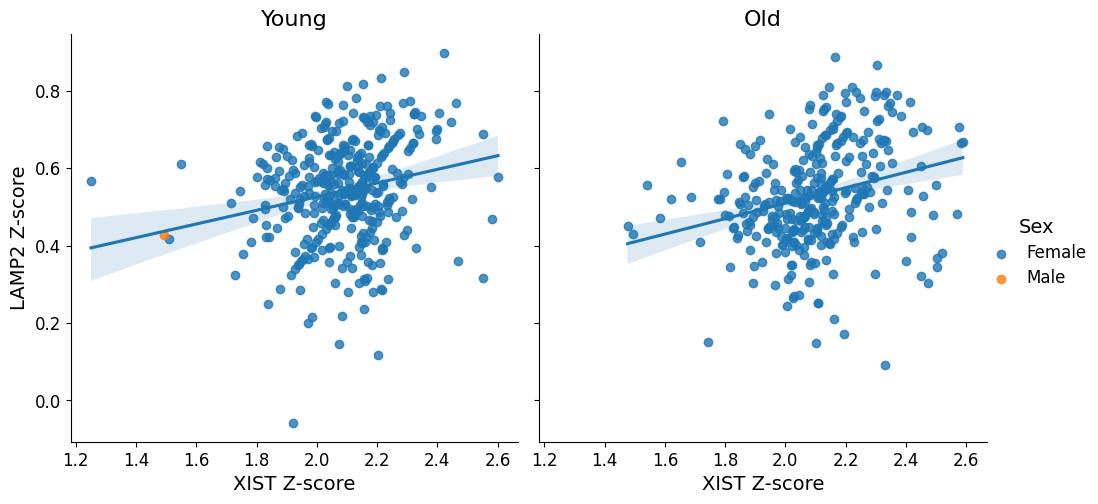

Loop finished


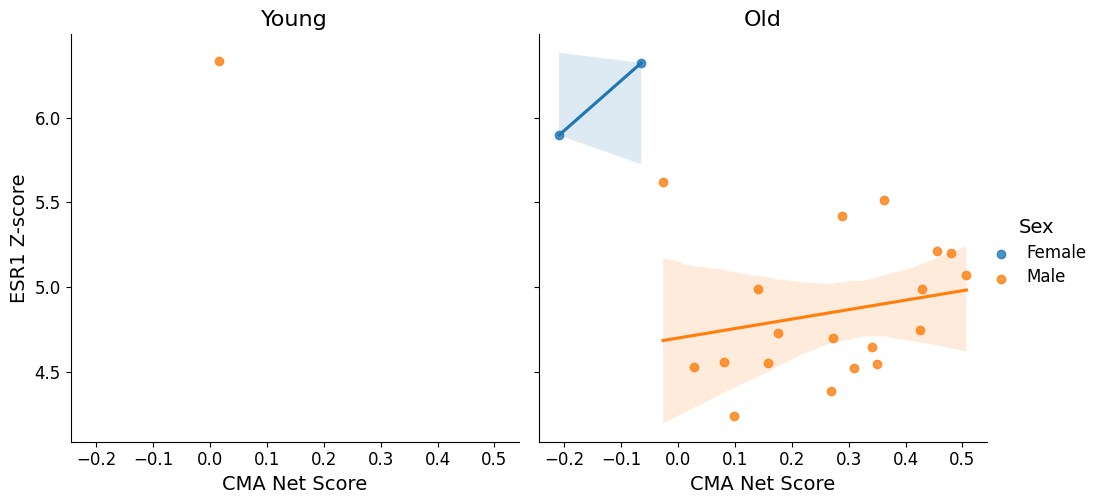

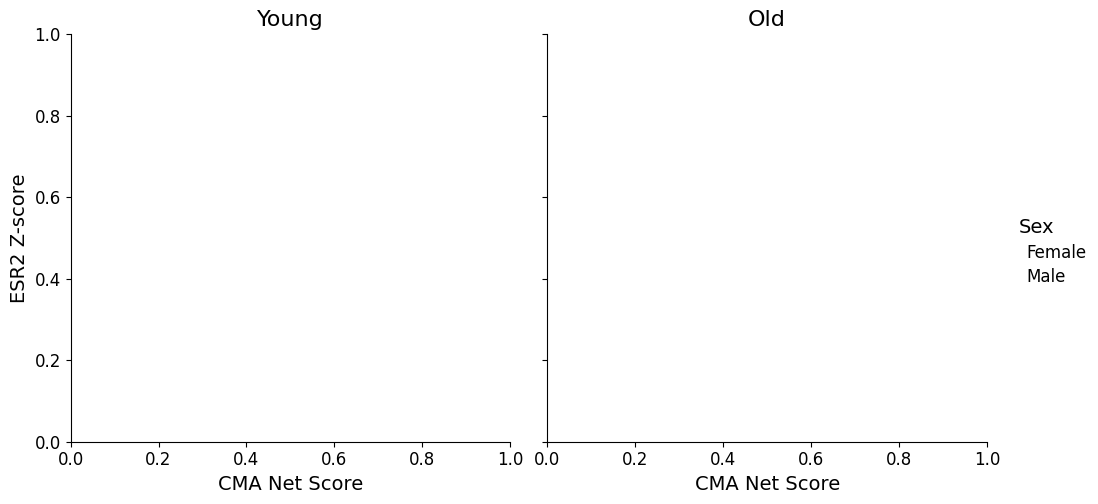

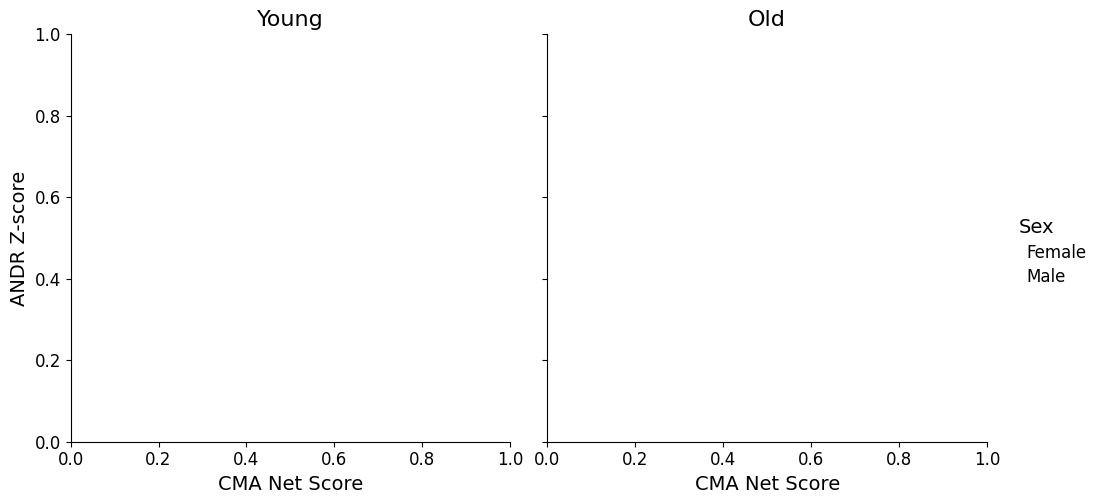

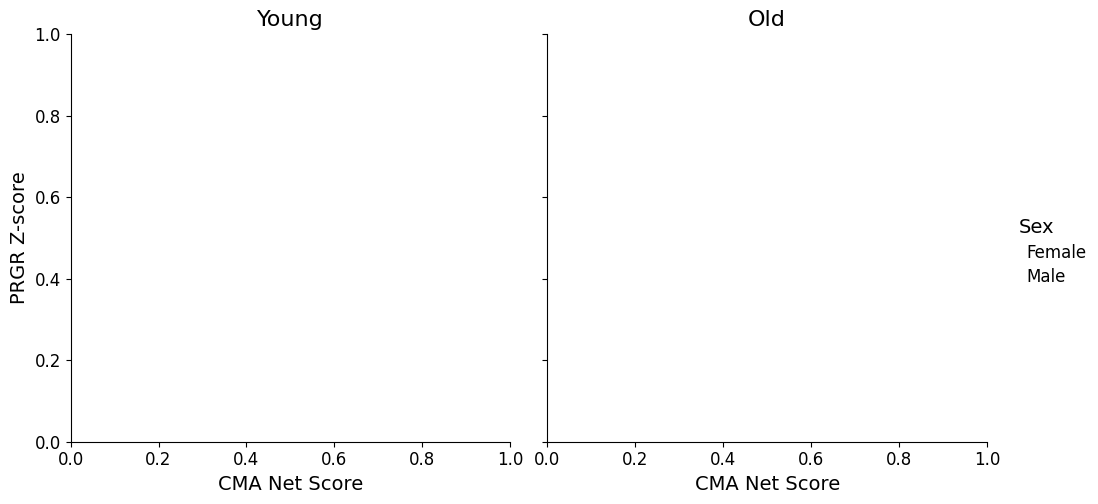

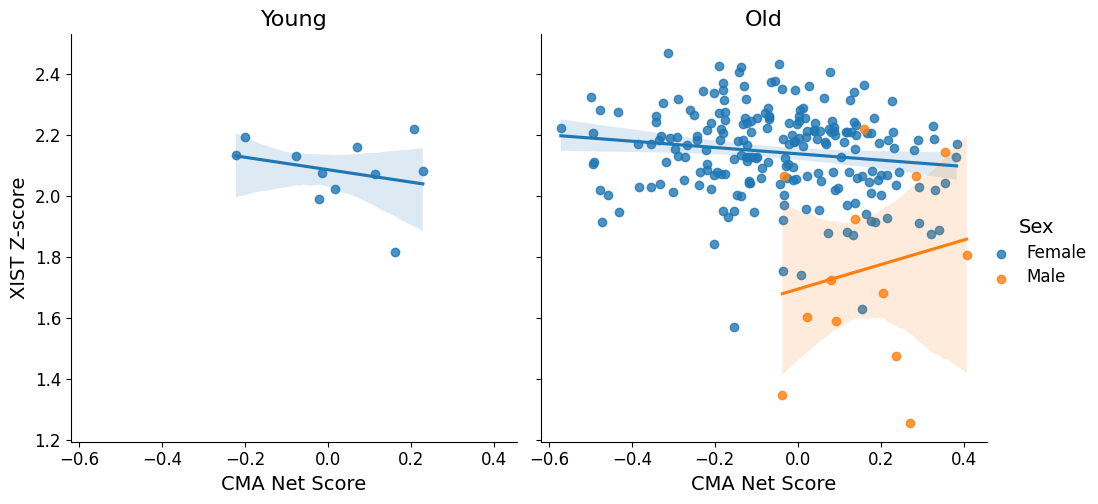

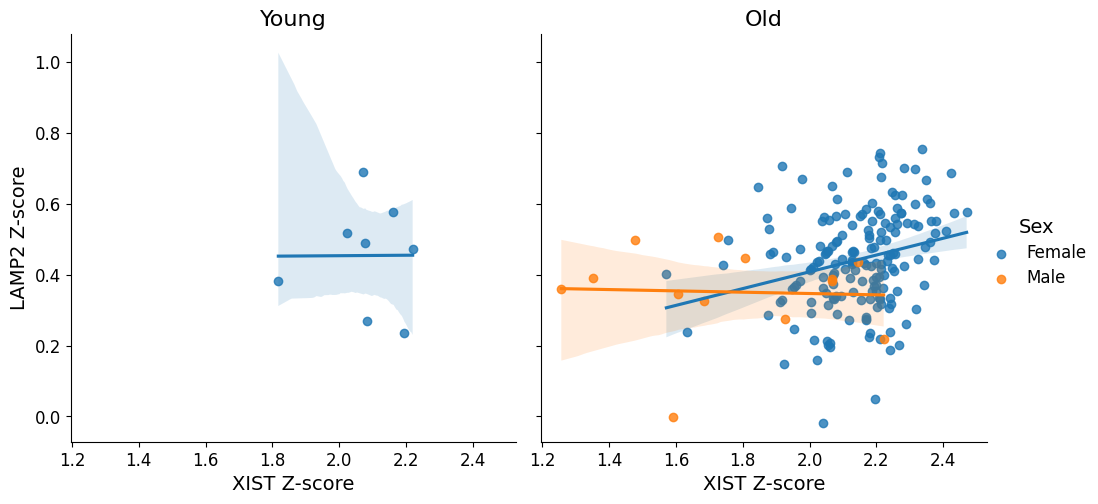

Loop finished


In [23]:
for i in cells:
    hormones(cellpop=i)

## USEFUL BUT NOT USED CODE BELOW THIS LINE
#####################################################################################


In [118]:
filt = barcode[barcode.cell_type=='Kupffer cell']
#filt = filt[filt['ESR1'] > np.min(filt.ESR1)]
filt.shape

(2546, 42)

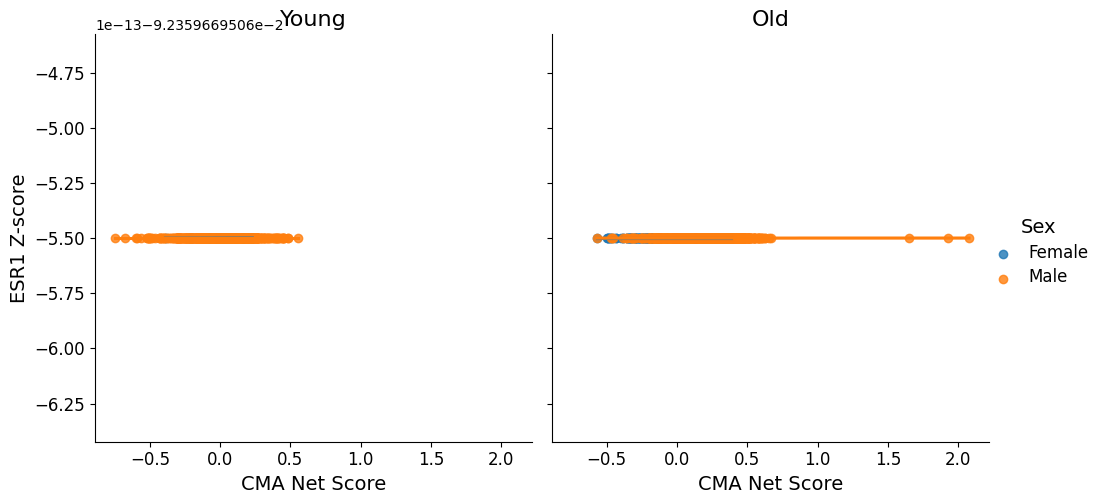

In [122]:
# Correlation removing 0 values
plot = sns.lmplot(filt, x="celltype_ns", y="ANDR", hue="sex", 
           hue_order = ("female", "male"), #palette=['#D7B0B0', '#808080'],
           col='new_age', col_wrap=2, col_order=['1-3m', '18-30m'], legend_out = True)
titles = ['Young', 'Old']
for ax, title in zip(plot.axes.flat, titles):
    ax.set_title(title, fontsize=16)
plot.set_axis_labels("CMA Net Score", "ESR1 Z-score", fontsize=14)

for ax in plot.axes.flat:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

new_labels = ['Female', 'Male']  # Nuevos labels para la leyenda
for t, l in zip(plot._legend.texts, new_labels):
    t.set_text(l)
plt.setp(plot._legend.get_title(), fontsize=14)  
plt.setp(plot._legend.get_texts(), fontsize=12)
plot._legend.set_title('Sex')

#plt.savefig(output_dir + '/liv10xhepandcor2.png',bbox_inches='tight', dpi=600)

plt.show()

In [ ]:
# Calculating pearson correlations
import scipy as sp
r, p = sp.stats.pearsonr(filt[filt.sex=='female'][filt.new_age=='1-3m']['ANDR'], filt[filt.sex=='female'][filt.new_age=='1-3m']['celltype_ns'])
r1, p1 = sp.stats.pearsonr(filt[filt.sex=='female'][filt.new_age=='18-30m']['ANDR'], filt[filt.sex=='female'][filt.new_age=='18-30m']['celltype_ns'])
r2, p2 = sp.stats.pearsonr(filt[filt.sex=='male'][filt.new_age=='1-3m']['ANDR'], filt[filt.sex=='male'][filt.new_age=='1-3m']['celltype_ns'])
r3, p3 = sp.stats.pearsonr(filt[filt.sex=='male'][filt.new_age=='18-30m']['ANDR'], filt[filt.sex=='male'][filt.new_age=='18-30m']['celltype_ns'])

print('Female Young ANDR vs Net Score R {} and P val {}'.format(r, p))
print('Female Old ANDR vs Net Score R {} and P val {}'.format(r1, p1))
print('Male Young ANDR vs Net Score R {} and P val {}'.format(r2, p2))
print('Male Old ANDR vs Net Score R {} and P val {}'.format(r3, p3))


Female Young ANDR vs Net Score R -0.31820336642638025 and P val 0.2297126543104328
Female Old ANDR vs Net Score R -0.3881825387242594 and P val 0.03744586354939499
Male Young ANDR vs Net Score R -0.5918617927120189 and P val 0.0714621867358518
Male Old ANDR vs Net Score R -0.652978605011329 and P val 0.5470382865737732


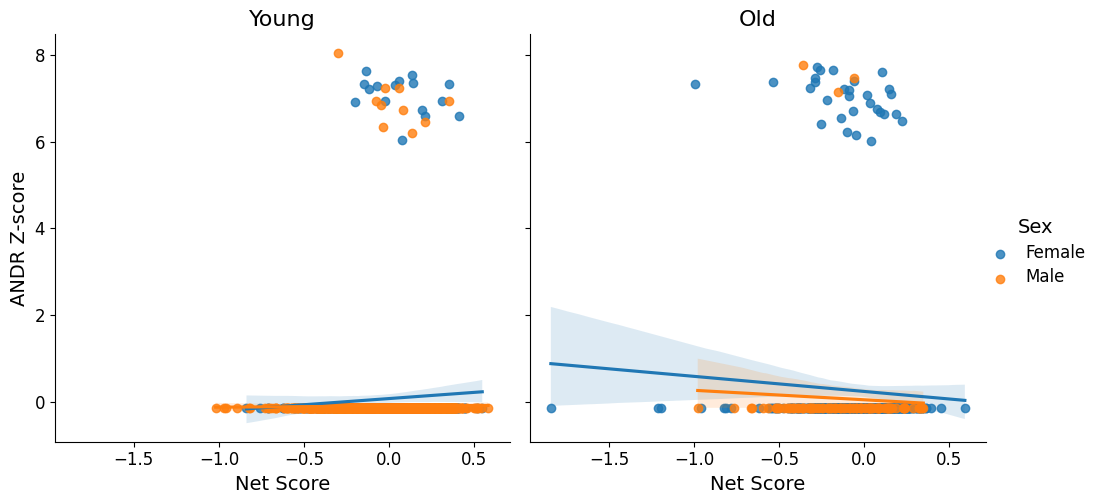

In [ ]:
# ANDR correlation
plot = sns.lmplot(barhep, x="celltype_ns", y="ANDR", hue="sex", 
           hue_order = ("female", "male"), #palette=['#D7B0B0', '#808080'],
           col='new_age', col_wrap=2, col_order=['1-3m', '18-30m'], legend_out = True)
titles = ['Young', 'Old']
for ax, title in zip(plot.axes.flat, titles):
    ax.set_title(title, fontsize=16)
plot.set_axis_labels("Net Score", "ANDR Z-score", fontsize=14)

for ax in plot.axes.flat:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

new_labels = ['Female', 'Male']  # Nuevos labels para la leyenda
for t, l in zip(plot._legend.texts, new_labels):
    t.set_text(l)
plt.setp(plot._legend.get_title(), fontsize=14)  
plt.setp(plot._legend.get_texts(), fontsize=12)
plot._legend.set_title('Sex')

plt.savefig(output_dir + '/liv10xhepandcor.png',bbox_inches='tight', dpi=600)

plt.show()

In [ ]:
# Calculating pearson correlations
import scipy as sp
r, p = sp.stats.pearsonr(barhep[barhep.sex=='female'][barhep.new_age=='1-3m']['ANDR'], barhep[barhep.sex=='female'][barhep.new_age=='1-3m']['celltype_ns'])
r1, p1 = sp.stats.pearsonr(barhep[barhep.sex=='female'][barhep.new_age=='18-30m']['ANDR'], barhep[barhep.sex=='female'][barhep.new_age=='18-30m']['celltype_ns'])
r2, p2 = sp.stats.pearsonr(barhep[barhep.sex=='male'][barhep.new_age=='1-3m']['ANDR'], barhep[barhep.sex=='male'][barhep.new_age=='1-3m']['celltype_ns'])
r3, p3 = sp.stats.pearsonr(barhep[barhep.sex=='male'][barhep.new_age=='18-30m']['ANDR'], barhep[barhep.sex=='male'][barhep.new_age=='18-30m']['celltype_ns'])

print('Female Young ANDR vs Net Score R {} and P val {}'.format(r, p))
print('Female Old ANDR vs Net Score R {} and P val {}'.format(r1, p1))
print('Male Young ANDR vs Net Score R {} and P val {}'.format(r2, p2))
print('Male Old ANDR vs Net Score R {} and P val {}'.format(r3, p3))


Female Young ANDR vs Net Score R 0.05204216588132437 and P val 0.22902833124727554
Female Old ANDR vs Net Score R -0.05076823032160429 and P val 0.24919842657412442
Male Young ANDR vs Net Score R 0.010372356445063118 and P val 0.6629558064611273
Male Old ANDR vs Net Score R -0.04720453324064496 and P val 0.6275868333067054


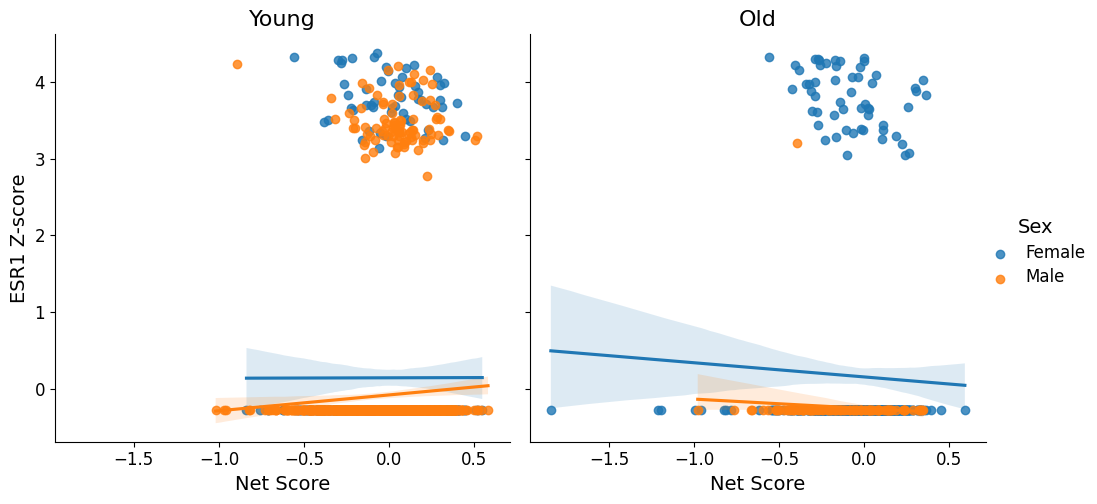

In [ ]:
# ESR1 correlation
plot = sns.lmplot(barhep, x="celltype_ns", y="ESR1", hue="sex", 
           hue_order = ("female", "male"), #palette=['#D7B0B0', '#808080'],
           col='new_age', col_wrap=2, col_order=['1-3m', '18-30m'], legend_out = True)
titles = ['Young', 'Old']
for ax, title in zip(plot.axes.flat, titles):
    ax.set_title(title, fontsize=16)
plot.set_axis_labels("Net Score", "ESR1 Z-score", fontsize=14)

for ax in plot.axes.flat:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

new_labels = ['Female', 'Male']  # Nuevos labels para la leyenda
for t, l in zip(plot._legend.texts, new_labels):
    t.set_text(l)
plt.setp(plot._legend.get_title(), fontsize=14)  
plt.setp(plot._legend.get_texts(), fontsize=12)
plot._legend.set_title('Sex')

plt.savefig(output_dir + '/liv10xhepesrcor.png',bbox_inches='tight', dpi=600)

plt.show()

In [ ]:
# Calculating pearson correlations
import scipy as sp
r, p = sp.stats.pearsonr(barhep[barhep.sex=='female'][barhep.new_age=='1-3m']['ESR1'], barhep[barhep.sex=='female'][barhep.new_age=='1-3m']['celltype_ns'])
r1, p1 = sp.stats.pearsonr(barhep[barhep.sex=='female'][barhep.new_age=='18-30m']['ESR1'], barhep[barhep.sex=='female'][barhep.new_age=='18-30m']['celltype_ns'])
r2, p2 = sp.stats.pearsonr(barhep[barhep.sex=='male'][barhep.new_age=='1-3m']['ESR1'], barhep[barhep.sex=='male'][barhep.new_age=='1-3m']['celltype_ns'])
r3, p3 = sp.stats.pearsonr(barhep[barhep.sex=='male'][barhep.new_age=='18-30m']['ESR1'], barhep[barhep.sex=='male'][barhep.new_age=='18-30m']['celltype_ns'])

print('Female Young ESR1 vs Net Score R {} and P val {}'.format(r, p))
print('Female Old ESR1 vs Net Score R {} and P val {}'.format(r1, p1))
print('Male Young ESR1 vs Net Score R {} and P val {}'.format(r2, p2))
print('Male Old ESR1 vs Net Score R {} and P val {}'.format(r3, p3))


Female Young ESR1 vs Net Score R 0.0010081493367565019 and P val 0.9814222505581913
Female Old ESR1 vs Net Score R -0.03492900853100458 and P val 0.4280560755134247
Male Young ESR1 vs Net Score R 0.05378430636548404 and P val 0.023725954996400185
Male Old ESR1 vs Net Score R -0.09857504495914436 and P val 0.3101172377072206


In [ ]:
filt = barhep[barhep['ESR1'] > -0.27]
filt.shape

(203, 38)

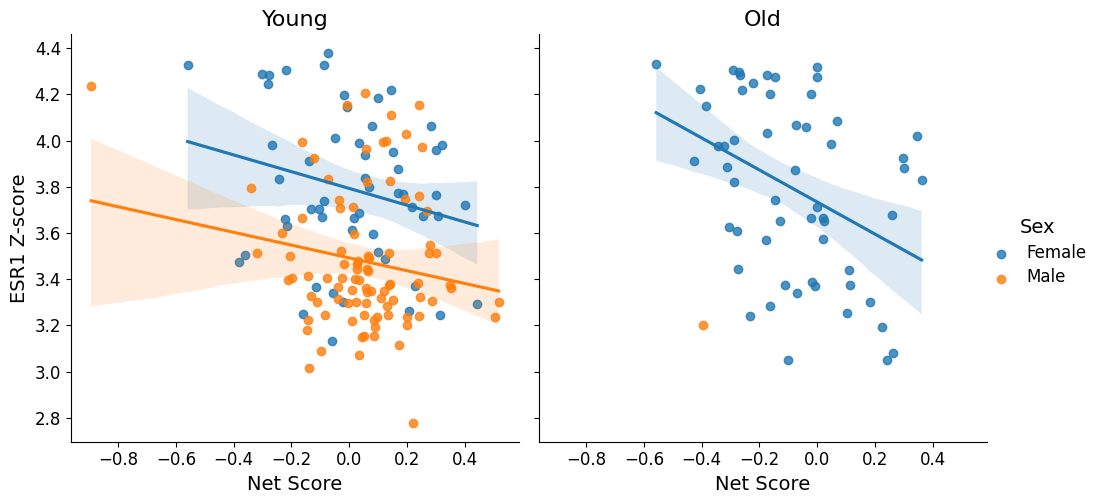

In [ ]:
# Correlation removing 0 values
plot = sns.lmplot(filt, x="celltype_ns", y="ESR1", hue="sex", 
           hue_order = ("female", "male"), #palette=['#D7B0B0', '#808080'],
           col='new_age', col_wrap=2, col_order=['1-3m', '18-30m'], legend_out = True)
titles = ['Young', 'Old']
for ax, title in zip(plot.axes.flat, titles):
    ax.set_title(title, fontsize=16)
plot.set_axis_labels("Net Score", "ESR1 Z-score", fontsize=14)

for ax in plot.axes.flat:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

new_labels = ['Female', 'Male']  # Nuevos labels para la leyenda
for t, l in zip(plot._legend.texts, new_labels):
    t.set_text(l)
plt.setp(plot._legend.get_title(), fontsize=14)  
plt.setp(plot._legend.get_texts(), fontsize=12)
plot._legend.set_title('Sex')

plt.savefig(output_dir + '/liv10xhepesrcor2.png',bbox_inches='tight', dpi=600)

plt.show()

In [ ]:
# Calculating pearson correlations
import scipy as sp
r, p = sp.stats.pearsonr(filt[filt.sex=='female'][filt.new_age=='1-3m']['ESR1'], filt[filt.sex=='female'][filt.new_age=='1-3m']['celltype_ns'])
r1, p1 = sp.stats.pearsonr(filt[filt.sex=='female'][filt.new_age=='18-30m']['ESR1'], filt[filt.sex=='female'][filt.new_age=='18-30m']['celltype_ns'])
r2, p2 = sp.stats.pearsonr(filt[filt.sex=='male'][filt.new_age=='1-3m']['ESR1'], filt[filt.sex=='male'][filt.new_age=='1-3m']['celltype_ns'])
#r3, p3 = sp.stats.pearsonr(filt[filt.sex=='male'][filt.new_age=='18-30m']['ESR1'], filt[filt.sex=='male'][filt.new_age=='18-30m']['celltype_ns'])

print('Female Young ESR1 vs Net Score R {} and P val {}'.format(r, p))
print('Female Old ESR1 vs Net Score R {} and P val {}'.format(r1, p1))
print('Male Young ESR1 vs Net Score R {} and P val {}'.format(r2, p2))
#print('Male Old ESR1 vs Net Score R {} and P val {}'.format(r3, p3))


Female Young ESR1 vs Net Score R -0.23964077810604031 and P val 0.07803901000457836
Female Old ESR1 vs Net Score R -0.39104773897296075 and P val 0.0028826468090952335
Male Young ESR1 vs Net Score R -0.17626658312613072 and P val 0.09465349035796544


In [ ]:
'ENSMUSG00000086503' in adata.var_names

True

In [ ]:
# Finding XIST
xistdf = adata[:, ['ENSMUSG00000016534', 'ENSMUSG00000086503']]

In [ ]:
# Restricting our matrix to hepatocytes
xisthep = xistdf[xistdf.obs['cell_type'].isin(['hepatocyte']), :]

In [ ]:
# Calculating Z scores and storing them in a layer
xisthep.layers["scaled"] = sc.pp.scale(xisthep, copy=True).X
xisthep

AnnData object with n_obs × n_vars = 2929 × 2
    obs: 'age', 'cell', 'free_annotation', 'method', 'donor_id', 'n_genes', 'subtissue', 'n_counts', 'louvain', 'leiden', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'age_colors', 'citation', 'leiden', 'louvain', 'neighbors', 'pca', 'schema_reference', 'schema_version', 'title', 'log1p'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'scaled'
    obsp: 'connec

In [ ]:
# Dataframe with Hormone Zs values
xisthepzs = pd.DataFrame(xisthep.layers['scaled'], columns = ['Lamp2', 'Xist'], index=xisthep.obs.index)
xisthepzs.head()

,Lamp2,Xist
index,,
AAACCTGAGATGTCGG-1-9-0-0,-3.019002,2.137862
AAAGCAATCGGAAATA-1-9-0-0,0.467695,1.468739
AAAGTAGAGGCCCTTG-1-9-0-0,0.350102,1.929051
AACCGCGAGAAACCGC-1-9-0-0,0.509186,1.865089
AACTCCCAGTTGTCGT-1-9-0-0,0.438995,1.678623


In [ ]:
# Merging Barcode and Hormonze Z values dataframe
barxist = barcode[barcode['cell_type']=='hepatocyte']
print(barxist.shape)
barxist = pd.merge(barxist, xisthepzs, how='inner', on='index')
barxist.head()

(2929, 34)


,age,cell,free_annotation,method,donor_id,n_genes,subtissue,n_counts,louvain,leiden,...,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age,net_score,celltype_ns,Lamp2,Xist
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGATGTCGG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAACCTGAGATGTCGG,nan,droplet,18-F-51,1116.0,Hepatocytes,3650.349121,0,5,...,liver,na,18 month-old stage,ghq^6>2Cj>,-0.802075,18-30m,-0.784992,-0.825102,-3.019002,2.137862
AAAGCAATCGGAAATA-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGCAATCGGAAATA,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1976.0,Hepatocytes,4931.057617,1,1,...,liver,na,18 month-old stage,0AZ4zIEVgc,0.022095,18-30m,0.039177,-0.000933,0.467695,1.468739
AAAGTAGAGGCCCTTG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGTAGAGGCCCTTG,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1897.0,Hepatocytes,5164.586426,1,1,...,liver,na,18 month-old stage,W7+}-!fosq,-0.367614,18-30m,-0.350531,-0.390641,0.350102,1.929051
AACCGCGAGAAACCGC-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACCGCGAGAAACCGC,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1501.0,Hepatocytes,4340.568359,1,1,...,liver,na,18 month-old stage,5zbU*lX{gq,-0.307166,18-30m,-0.290083,-0.330193,0.509186,1.865089
AACTCCCAGTTGTCGT-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACTCCCAGTTGTCGT,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1710.0,Hepatocytes,4656.192871,1,1,...,liver,na,18 month-old stage,wvv9<D^@o-,-0.265595,18-30m,-0.248513,-0.288623,0.438995,1.678623


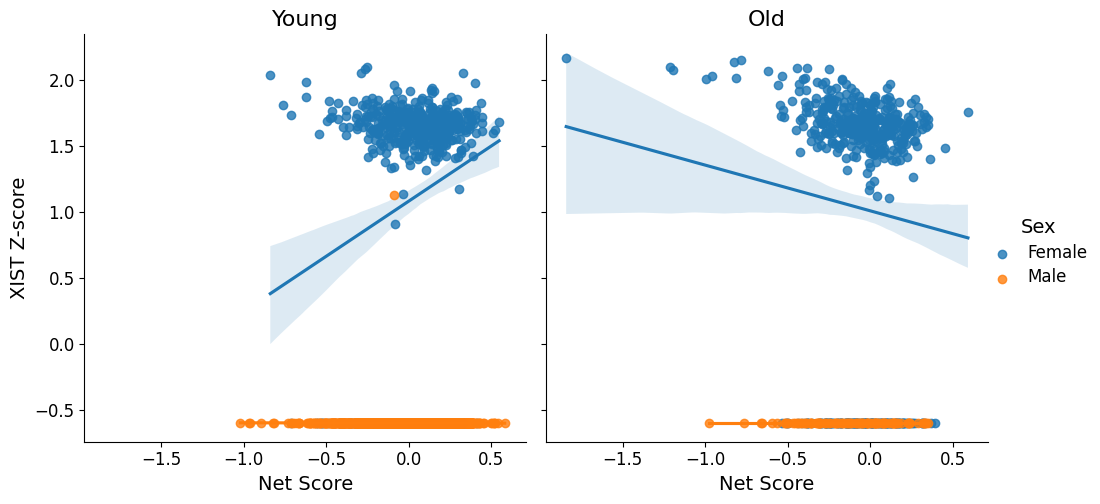

In [ ]:
# ANDR correlation
plot = sns.lmplot(barxist, x="celltype_ns", y="ENSMUSG00000086503", hue="sex", 
           hue_order = ("female", "male"), #palette=['#D7B0B0', '#808080'],
           col='new_age', col_wrap=2, col_order=['1-3m', '18-30m'], legend_out = True)
titles = ['Young', 'Old']
for ax, title in zip(plot.axes.flat, titles):
    ax.set_title(title, fontsize=16)
plot.set_axis_labels("Net Score", "XIST Z-score", fontsize=14)

for ax in plot.axes.flat:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

new_labels = ['Female', 'Male']  # Nuevos labels para la leyenda
for t, l in zip(plot._legend.texts, new_labels):
    t.set_text(l)
plt.setp(plot._legend.get_title(), fontsize=14)  
plt.setp(plot._legend.get_texts(), fontsize=12)
plot._legend.set_title('Sex')

plt.savefig(output_dir + '/liv10xhepxiscor.png',bbox_inches='tight', dpi=600)

plt.show()

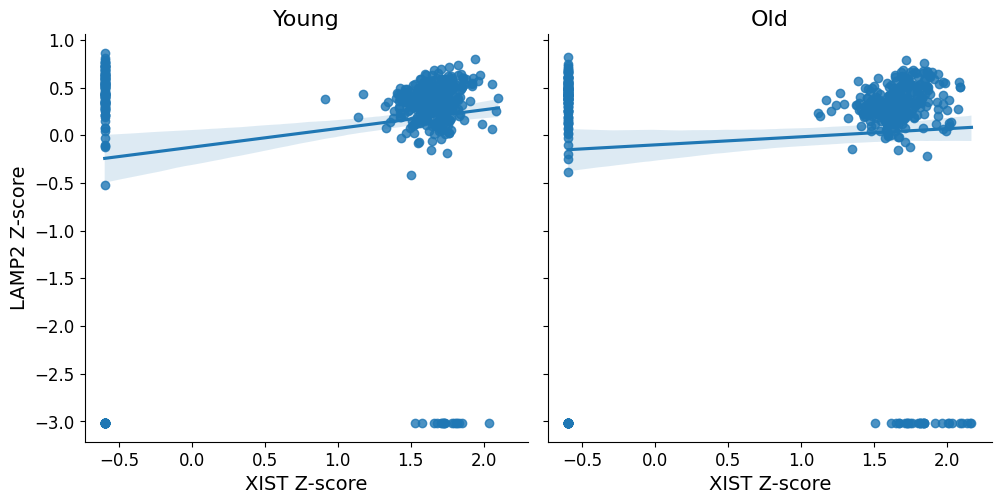

In [ ]:
# XIST-LAMP2 correlation
plot = sns.lmplot(data=barxist[barxist['sex']=='female'], x="Xist", y="Lamp2",  
           col='new_age', col_wrap=2, col_order=['1-3m', '18-30m'], legend_out = True)
titles = ['Young', 'Old']
for ax, title in zip(plot.axes.flat, titles):
    ax.set_title(title, fontsize=16)
plot.set_axis_labels("XIST Z-score", "LAMP2 Z-score", fontsize=14)

for ax in plot.axes.flat:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

new_labels = ['Female', 'Male']  # Nuevos labels para la leyenda


plt.savefig(output_dir + '/liv10xhepxisl2.png',bbox_inches='tight', dpi=600)

plt.show()

In [ ]:
filt = barxist[(barxist['Xist'] > -0.59) & (barxist['sex']=='female')]
filt.shape

(772, 36)

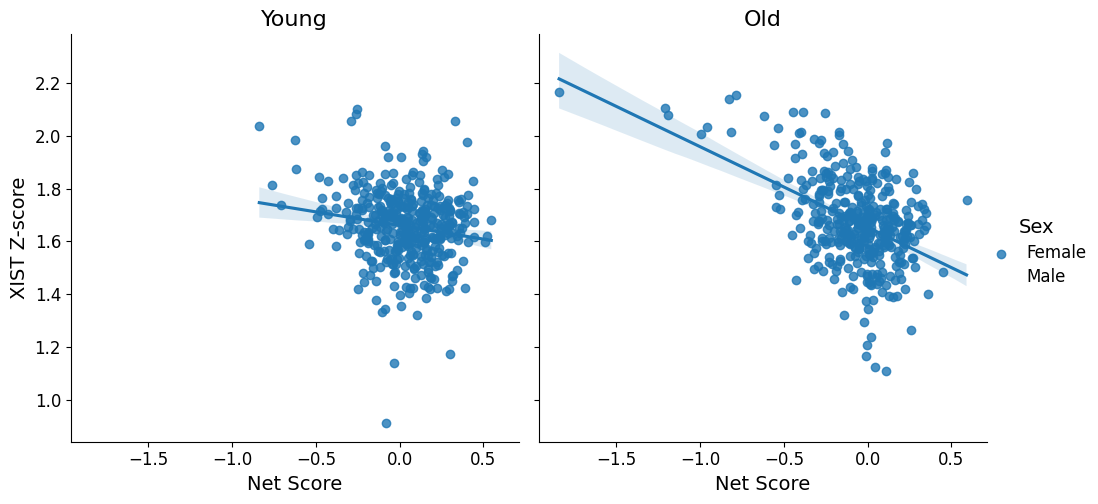

In [ ]:
# Correlation removing 0 values
plot = sns.lmplot(filt, x="celltype_ns", y="ENSMUSG00000086503", hue="sex", 
           hue_order = ("female", "male"), #palette=['#D7B0B0', '#808080'],
           col='new_age', col_wrap=2, col_order=['1-3m', '18-30m'], legend_out = True)
titles = ['Young', 'Old']
for ax, title in zip(plot.axes.flat, titles):
    ax.set_title(title, fontsize=16)
plot.set_axis_labels("Net Score", "XIST Z-score", fontsize=14)

for ax in plot.axes.flat:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

new_labels = ['Female', 'Male']  # Nuevos labels para la leyenda
for t, l in zip(plot._legend.texts, new_labels):
    t.set_text(l)
plt.setp(plot._legend.get_title(), fontsize=14)  
plt.setp(plot._legend.get_texts(), fontsize=12)
plot._legend.set_title('Sex')

plt.savefig(output_dir + '/liv10xhepxiscor2.png',bbox_inches='tight', dpi=600)

plt.show()

In [ ]:
# Calculating pearson correlations
r, p = sp.stats.pearsonr(filt[filt.sex=='female'][filt.new_age=='1-3m']['ENSMUSG00000086503'], filt[filt.sex=='female'][filt.new_age=='1-3m']['celltype_ns'])
r1, p1 = sp.stats.pearsonr(filt[filt.sex=='female'][filt.new_age=='18-30m']['ENSMUSG00000086503'], filt[filt.sex=='female'][filt.new_age=='18-30m']['celltype_ns'])

print('Female Young XIST vs Net Score R {} and P val {}'.format(r, p))
print('Female Old XIST vs Net Score R {} and P val {}'.format(r1, p1))


Female Young XIST vs Net Score R -0.16482335055035138 and P val 0.0009231156645836666
Female Old XIST vs Net Score R -0.46460946853646534 and P val 2.899423726038191e-21
